# Forecasting the Commute: Modelling Weather Effects on Wellington Traffic
### Rachel Anastasi-Marais
#### Capstone Project, November 2025

*   This Notebook contains data cleaning, EDA, and Feature Engineering



Residents in Wellington, New Zealand have been observed driving more when the weather is wet and windy. Conversely, on a bright sunny day the City attracts a lot of visitors. This project aims to investigate the relationship between strength of weather as a predictor of traffic volumes on weekdays.

Traffic data sourced from https://wellingtontransportanalytics.co.nz was collected between February and November 2024. Historical weather data was accessed via API from open-meteo.com using averaged latitude and longitude values from traffic count sites, reflecting "North", "South, "East", "West", and "Central" areas.

The final data set contains traffic and weather data for 119 weekdays.

Access NZTA TMS Daily Traffic Counts API

### Pip Installs

In [ ]:
!apt-get install -y openjdk-11-jdk-headless
!pip install pyspark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
!pip install geopy shapely

In [ ]:
!pip install openpyxl

### Import Libraries

In [ ]:
import requests
import json

import pandas as pd
import numpy as np

import openpyxl as xl
from pyproj import transformer, Transformer

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, rank

from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType, IntegerType, DateType
from pyspark.sql.window import Window

import folium
from geopy.distance import geodesic
from shapely.geometry import Polygon, Point, MultiPoint

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Initialise a Spark session
spark = (SparkSession.builder.appName("WeatherVsTraffic2").getOrCreate())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Wellington local traffic data
Traffic data is separated into data with and without site_id_global values. Data without site_id_global values is from sections of road that are overall longer than those sites with site_id_global provided.

All sites were assessed for travel direction, "in" or "out" relative to the approach from that road toward Central Wellington.
Excluded sites were one-way roads with zero contraflow (bike lane or otherwise).
These sites were removed before importing traffic files.

### Import Wellington local traffic count site data

---



In [ ]:
# Read Excel file into a pandas DataFrame
traffic_pdf = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/WCC_2024_selections v2.xlsx', sheet_name="WCC_sites_2024", engine="openpyxl")

# Convert pandas DataFrame to Spark DataFrame
traffic_sites_sdf = spark.createDataFrame(traffic_pdf)

In [ ]:
traffic_sites_sdf.count()

92

In [ ]:
# Read Excel file into a pandas DataFrame
traffic_pdf2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/WCC_2024_selections_no_global_id.xlsx', sheet_name="WCC_sites_2024_no_global_id", engine="openpyxl")

# Convert pandas DataFrame to Spark DataFrame
traffic_sites_sdf2 = spark.createDataFrame(traffic_pdf2)

In [ ]:
traffic_sites_sdf2.count()

144

In [ ]:
# union traffic_sites_sdf and traffic_sites_sdf2
traffic_sites_sdf = traffic_sites_sdf.unionByName(traffic_sites_sdf2)

In [ ]:
# Convert Easting and Northing values from spark_traffic_df into latitude and longitude

# Define transformer (NZTM2000 to WGS84) - Assuming NZTM2000 for Wellington, please verify
transformer = Transformer.from_crs("EPSG:2193", "EPSG:4326", always_xy=True)

# Define a UDF to perform the transformation
@udf(returnType=StructType([StructField("lon", DoubleType()), StructField("lat", DoubleType())]))
def transform_coords(easting_str, northing_str):
    try:
        # Extract numeric values from strings like 'E1748581' and 'N5424151'
        easting = float(easting_str[1:])
        northing = float(northing_str[1:])
        lon, lat = transformer.transform(easting, northing)
        return (lon, lat)
    except (ValueError, TypeError, IndexError):
        return (None, None)

# Apply the UDF to create new 'coordinates' column
traffic_sites_sdf = traffic_sites_sdf.withColumn(
    "coordinates",
    transform_coords(F.col("Easting"), F.col("Northing"))
)

# Extract lon and lat into separate columns
traffic_sites_sdf = traffic_sites_sdf.withColumn("Longitude", F.col("coordinates.lon"))
traffic_sites_sdf = traffic_sites_sdf.withColumn("Latitude", F.col("coordinates.lat"))

# Drop the intermediate 'coordinates' column if not needed
traffic_sites_sdf = traffic_sites_sdf.drop("coordinates")


print("DataFrame with Latitude and Longitude:")
traffic_sites_sdf.select("site_code", "Easting", "Northing", "Longitude", "Latitude").show(5, truncate=False)

DataFrame with Latitude and Longitude:
+------------+--------+--------+------------------+-------------------+
|site_code   |Easting |Northing|Longitude         |Latitude           |
+------------+--------+--------+------------------+-------------------+
|Adelaide Rd |E1748581|N5424151|174.77527468398802|-41.32043069230852 |
|Amesbury Dr |E1751095|N5437547|174.8019790493776 |-41.199354568793275|
|Arun Cres   |E1749036|N5422791|174.781042106202  |-41.33259130846648 |
|Boulcott St |E1748426|N5428038|174.77247539658578|-41.28546285609273 |
|Britomart St|E1748519|N5424126|174.77454034419068|-41.32066719868946 |
+------------+--------+--------+------------------+-------------------+
only showing top 5 rows



In [ ]:
distinct_count = traffic_sites_sdf.select("site_id","site_id_global").distinct().count()
print(f"Distinct site_id & site_id_global count: {distinct_count}")

traffic_sites_sdf.show(truncate=False)

Distinct site_id & site_id_global count: 236
+-------+-------------+--------------------------------------------------------------+----------------------------------------------------------------------------+-----------------+--------+--------+--------------+------------------+-------------------+
|site_id|site_code    |site_desc                                                     |site_description                                                            |location         |Easting |Northing|site_id_global|Longitude         |Latitude           |
+-------+-------------+--------------------------------------------------------------+----------------------------------------------------------------------------+-----------------+--------+--------+--------------+------------------+-------------------+
|2      |Adelaide Rd  |Adelaide Rd - Luxford St to Britomart St                      |ADELAIDE RD RC#1514 BTWN LUXFORD ST AND BRITOMART ST OS#472                 |E1748581 N5424151|E1748581|N54

### Visualize Traffic count sites with Folium

In [ ]:
# count site_id values from traffic_sites_sdf
site_counts = traffic_sites_sdf.groupBy("site_id").count()
site_counts.orderBy("count", ascending=False).show(10)

+-------+-----+
|site_id|count|
+-------+-----+
|     54|    1|
|    112|    1|
|     34|    1|
|    126|    1|
|    110|    1|
|     57|    1|
|     32|    1|
|     43|    1|
|     39|    1|
|    116|    1|
+-------+-----+
only showing top 10 rows



#### Folium Map of traffic count sites
This map shows both traffic count sites with site_id_global (blue), and without (green). Central Wellington is represented by a red circle.

In [ ]:
## Folium map of traffic count sites

# Convert Spark DataFrame to Pandas DataFrame for Folium

filtered_df = (
    traffic_sites_sdf
    .filter(F.col("site_id").isNotNull() & ~F.isnan("site_id"))
    .filter(F.col("Latitude").isNotNull() & ~F.isnan("Latitude"))
    .filter(F.col("Longitude").isNotNull() & ~F.isnan("Longitude"))
)

traffic_sites_pdf = filtered_df.select("site_code","site_id","site_id_global","site_desc","Latitude","Longitude").toPandas()

# Base map
m = folium.Map(location=[-41.2865, 174.7762], zoom_start=12)

# Iterate through rows and style markers by condition
for _, row in traffic_sites_pdf.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        popup_text = f"{row['site_code']} - {row['site_id_global']} - {row['site_id']} - {row['site_desc']}"

        # Choose colour based on whether site_id_global is present
        if pd.notnull(row['site_id_global']):
            marker_color = "blue"   # dataset with site_id_global
        else:
            marker_color = "green"  # dataset with alt_id / only site_id

        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup_text,
            icon=folium.Icon(color=marker_color, icon="info-sign")
        ).add_to(m)

# Add a large opaque red circle for the CBD
folium.Circle(
    location=[-41.2865, 174.7762],
    radius=1300,
    color="red",
    fill=True,
    fill_color="red",
    fill_opacity=0.5,
    popup="Wellington CBD"
).add_to(m)

# Display the map
m

### Import granular Wellington traffic data
The more granular traffic data relates to traffic counts collected by dual tubes placed across sealed roads.
Traffic counts are quarter-hourly, by date and site.
Additional values "ToD" (Time of Day, ie AM or PM), and "direction#" were added to help flag "use". For example, vehicle counts for a street with measures Northbound vs Southbound received `direction#=1` for Northbound, `direction#=2` for Southbound. Eastbound and Westbound received 3 and 4, respectively.
Traffic into the city received `use = in`, whereas traffic away from the city received `use = out`.
Use and direction# were each manually determined.

In [ ]:
# Import granular traffic detail
# Read Excel file into a pandas DataFrame
traffic_detail_pdf = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/WCC_2024_selections v2.xlsx', sheet_name="WCC_tube_count_2024", engine="openpyxl")

# Convert pandas DataFrame to Spark DataFrame
traffic_detail_sdf = spark.createDataFrame(traffic_detail_pdf)

In [ ]:
traffic_detail_pdf.count()

quarter hourly from    41216
quarter hourly to      41216
ToD                    41216
count_total            41216
date                   41216
weekday                41216
direction              41216
direction_label        41216
"direction" #          41216
filename               41216
site_code              40768
use                    41216
site_id                41216
site_id_global         41216
dtype: int64

In [ ]:
# Import granular traffic detail for sites without site_id_global
# Read Excel file into a pandas DataFrame
traffic_detail_pdf2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/WCC_2024_selections_no_global_id.xlsx', sheet_name="WCC_tube_count_2024_no_global", engine="openpyxl")

# Convert pandas DataFrame to Spark DataFrame
traffic_detail_sdf2 = spark.createDataFrame(traffic_detail_pdf2)

In [ ]:
traffic_detail_sdf2.count()

40820

In [ ]:
traffic_detail_pdf

quarter hourly from  quarter hourly to ToD  count_total        date  \
0                      600                615  AM           39  2024-03-21   
1                      600                615  AM           26  2024-03-22   
2                      600                615  AM           17  2024-03-23   
3                      600                615  AM            7  2024-03-24   
4                      600                615  AM           36  2024-03-25   
...                    ...                ...  ..          ...         ...   
41211                 1845               1900  PM            5  2024-02-19   
41212                 1845               1900  PM           11  2024-02-20   
41213                 1845               1900  PM           11  2024-02-21   
41214                 1845               1900  PM            7  2024-02-22   
41215                 1845               1900  PM           16  2024-02-23   

      weekday  direction direction_label  "direction" #  \
0         Thu          2      Northbound              1   
1         Fri          2      Northbound              1   
2         Sat          2      Northbound              1   
3         Sun          2      Northbound              1   
4         Mon          2      Northbound              1   
...       ...        ...             ...            ...   
41211     Mon          1      Southbound              2   
41212     Tue          1      Southbound              2   
41213     Wed          1      Southbound              2   
41214     Thu          1      Southbound              2   
41215     Fri          1      Southbound              2   

                                                filename    site_code  use  \
0      Adelaide Rd - Luxford St to Britomart St 20240...  Adelaide Rd  out   
1      Adelaide Rd - Luxford St to Britomart St 20240...  Adelaide Rd  out   
2      Adelaide Rd - Luxford St to Britomart St 20240...  Adelaide Rd  out   
3      Adelaide Rd - Luxford St to Britomart St 20240...  Adelaide Rd  out   
4      Adelaide Rd - Luxford St to Britomart St 20240...  Adelaide Rd  out   
...                                                  ...          ...  ...   
41211  Wright St - Salisbury Tce to Hutchison Rd 2024...    Wright St  out   
41212  Wright St - Salisbury Tce to Hutchison Rd 2024...    Wright St  out   
41213  Wright St - Salisbury Tce to Hutchison Rd 2024...    Wright St  out   
41214  Wright St - Salisbury Tce to Hutchison Rd 2024...    Wright St  out   
41215  Wright St - Salisbury Tce to Hutchison Rd 2024...    Wright St  out   

       site_id  site_id_global  
0            2            1073  
1            2            1073  
2            2            1073  
3            2            1073  
4            2            1073  
...        ...             ...  
41211      241            1167  
41212      241            1167  
41213      241            1167  
41214      241            1167  
41215      241            1167  

[41216 rows x 14 columns]

In [ ]:
# union traffic_detail_sdf and traffic_detail_sdf2

# Ensure both DataFrames have the same columns
df1 = traffic_detail_sdf
df2 = traffic_detail_sdf2

# Add missing columns with nulls (cast to correct type for consistency)
if "alt_id" not in df1.columns:
    df1 = df1.withColumn("alt_id", F.lit(None).cast("string"))

if "site_id_global" not in df2.columns:
    df2 = df2.withColumn("site_id_global", F.lit(None).cast("int"))

# Now union by name safely
traffic_detail_sdf = df1.unionByName(df2)

In [ ]:
traffic_detail_sdf.count()

82036

In [ ]:
distinct_count = traffic_detail_sdf.select("site_id","site_id_global").distinct().count()
print(f"Distinct site_id_global and site_id count: {distinct_count}")

traffic_detail_sdf.show(5, truncate=False)

Distinct site_id_global and site_id count: 236
+-------------------+-----------------+---+-----------+----------+-------+---------+---------------+-------------+------------------------------------------------------+-----------+---+-------+--------------+------+
|quarter hourly from|quarter hourly to|ToD|count_total|date      |weekday|direction|direction_label|"direction" #|filename                                              |site_code  |use|site_id|site_id_global|alt_id|
+-------------------+-----------------+---+-----------+----------+-------+---------+---------------+-------------+------------------------------------------------------+-----------+---+-------+--------------+------+
|600                |615              |AM |39         |2024-03-21|Thu    |2        |Northbound     |1            |Adelaide Rd - Luxford St to Britomart St 20240321.xlsx|Adelaide Rd|out|2      |1073.0        |NULL  |
|600                |615              |AM |26         |2024-03-22|Fri    |2        |North

In [ ]:
traffic_detail_sdf.groupBy(
   "site_id","site_id_global","site_code", "use", "ToD"
).count().orderBy("site_id_global").show(20)

+-------+--------------+------------+---+---+-----+
|site_id|site_id_global|   site_code|use|ToD|count|
+-------+--------------+------------+---+---+-----+
|      2|        1073.0| Adelaide Rd| in| AM|   98|
|      2|        1073.0| Adelaide Rd|out| PM|  126|
|      2|        1073.0| Adelaide Rd|out| AM|   98|
|      2|        1073.0| Adelaide Rd| in| PM|  126|
|      4|        1074.0| Amesbury Dr| in| PM|  126|
|      4|        1074.0| Amesbury Dr|out| PM|  126|
|      4|        1074.0| Amesbury Dr| in| AM|   98|
|      4|        1074.0| Amesbury Dr|out| AM|   98|
|      9|        1075.0|   Arun Cres| in| PM|  126|
|      9|        1075.0|   Arun Cres|out| AM|   98|
|      9|        1075.0|   Arun Cres|out| PM|  126|
|      9|        1075.0|   Arun Cres| in| AM|   98|
|     13|        1076.0| Boulcott St| in| AM|   98|
|     13|        1076.0| Boulcott St|out| AM|   98|
|     13|        1076.0| Boulcott St|out| PM|  126|
|     13|        1076.0| Boulcott St| in| PM|  126|
|     15|   

In [ ]:
# Check datatypes for site_id in sites and details datasets (our joining column)
print(traffic_detail_sdf.schema["site_id"].dataType)
print(traffic_sites_sdf.schema["site_id"].dataType)

# Check datatypes for site_id_global in sites and details datasets (our joining column)
print(traffic_detail_sdf.schema["site_id_global"].dataType)
print(traffic_sites_sdf.schema["site_id_global"].dataType)

LongType()
LongType()
DoubleType()
DoubleType()


In [ ]:
# Check the distribution of site_id_global in traffic_detail_sdf
traffic_detail_sdf.groupBy("site_id_global").count().show()

# Check the count of rows where site_id_global is null in traffic_detail_sdf
traffic_detail_sdf.filter(F.col("site_id_global").isNull()).count()

+--------------+-----+
|site_id_global|count|
+--------------+-----+
|        1095.0|  448|
|        1084.0|  448|
|        1091.0|  448|
|        1081.0|  448|
|        1074.0|  448|
|        1092.0|  448|
|        1112.0|  448|
|        1073.0|  448|
|        1075.0|  448|
|        1116.0|  448|
|        1101.0|  448|
|        1078.0|  448|
|        1109.0|  448|
|        1076.0|  448|
|        1114.0|  448|
|        1108.0|  448|
|        1117.0|  448|
|        1110.0|  448|
|        1105.0|  448|
|        1089.0|  448|
+--------------+-----+
only showing top 20 rows



0

In [ ]:
# Check for duplicate sites in traffic_sites_sdf based on join keys
site_duplicates = (
    traffic_sites_sdf
    .groupBy("site_id_global", "site_id", "site_desc")
    .count()
    .filter(F.col("count") > 1)
)

print("Duplicate site entries in traffic_sites_sdf:")
site_duplicates.show(truncate=False)

Duplicate site entries in traffic_sites_sdf:
+--------------+-------+---------+-----+
|site_id_global|site_id|site_desc|count|
+--------------+-------+---------+-----+
+--------------+-------+---------+-----+



In [ ]:
# Check sites are unique
sites_unique = traffic_sites_sdf.dropDuplicates(["site_id", "site_id_global"])
print(f"Unique sites: {sites_unique.count()}")

Unique sites: 236


In [ ]:
# Alias for readability
sites = traffic_sites_sdf.alias("s")
details = traffic_detail_sdf.alias("d")

# Filter sites for valid global IDs (not null and not NaN)
sites_with_global_id_valid = sites.filter(F.col("s.site_id_global").isNotNull() & ~F.isnan("s.site_id_global"))

# Filter details for valid global IDs (not null and not NaN)
# Based on previous checks, site_id_global is never null in details, but let's be safe
details_with_global_id_valid = details.filter(F.col("d.site_id_global").isNotNull() & ~F.isnan("d.site_id_global"))


# Perform the global join using a simple equality condition
global_join = (
    sites_with_global_id_valid.join(
        details_with_global_id_valid,
        on="site_id_global", # Join using the column name since it's the same in both filtered DFs
        how="inner"
    )
    .select(
        F.col("s.site_id").alias("site_id"),
        F.col("s.site_id_global").alias("site_id_global"),
        F.col("s.site_code").alias("site_code"),
        F.col("s.site_desc").alias("site_desc"),
        F.col("s.longitude").alias("longitude"),
        F.col("s.latitude").alias("latitude"),
        F.col("d.`quarter hourly from`").alias("quarter hourly from"),
        F.col("d.`quarter hourly to`").alias("quarter hourly to"),
        F.col("d.ToD").alias("ToD"),
        F.col("d.date").alias("date"),
        F.col("d.weekday").alias("weekday"),
        F.col("d.count_total").alias("count_total"),
        F.col("d.direction_label").alias("direction_label"),
        F.col("d.use").alias("use"),
        F.col("d.alt_id").alias("alt_id") # Include alt_id even if not used for joining
    )
    .withColumn("join_type", F.lit("global"))
)
print(f"\nRow count after global_join: {global_join.count()}")


# Handle the fallback join part - joining sites without valid global ID to details without valid global ID
# Filter sites where site_id_global is null OR is NaN
sites_without_global_id = sites.filter(F.col("s.site_id_global").isNull() | F.isnan("s.site_id_global"))
# Filter details where site_id_global is null OR is NaN
details_without_global_id = details.filter(F.col("d.site_id_global").isNull() | F.isnan("d.site_id_global"))


# Perform the fallback join on site_id and site_desc/alt_id
fallback_join = (
    sites_without_global_id.join(
        details_without_global_id,
        on=[
            sites_without_global_id["site_id"] == details_without_global_id["site_id"],
            sites_without_global_id["site_desc"] == details_without_global_id["alt_id"]
        ],
        how="inner"
    )
    .select(
        F.col("s.site_id").alias("site_id"), # Keep original site_id for the fallback join part
        F.col("s.site_id_global").alias("site_id_global"),
        F.col("s.site_code").alias("site_code"),
        F.col("s.site_desc").alias("site_desc"),
        F.col("s.longitude").alias("longitude"),
        F.col("s.latitude").alias("latitude"),
        F.col("d.`quarter hourly from`").alias("quarter hourly from"),
        F.col("d.`quarter hourly to`").alias("quarter hourly to"),
        F.col("d.ToD").alias("ToD"),
        F.col("d.date").alias("date"),
        F.col("d.weekday").alias("weekday"),
        F.col("d.count_total").alias("count_total"),
        F.col("d.direction_label").alias("direction_label"),
        F.col("d.use").alias("use"),
        F.col("d.alt_id").alias("alt_id")
    )
    .withColumn("join_type", F.lit("fallback"))
)
print(f"Row count after fallback_join: {fallback_join.count()}")

# Combine both join results
# Use unionByName to handle potential column order differences if needed, though select aligns them
traffic_sdf = global_join.unionByName(fallback_join)


traffic_sdf.printSchema()
print(f"\nRow count after union: {traffic_sdf.count()}")
traffic_sdf.show(5)

# Re-check the counts of each site_id_global and site_id/alt_id combination in traffic_detail_sdf
print("\nCounts of each site_id_global in traffic_detail_sdf:")
traffic_detail_sdf.groupBy("site_id_global").count().show()

print("\nCounts of each site_id/alt_id in traffic_detail_sdf:")
traffic_detail_sdf.groupBy("site_id", "alt_id").count().show()


Row count after global_join: 41216
Row count after fallback_join: 40820
root
 |-- site_id: long (nullable = true)
 |-- site_id_global: double (nullable = true)
 |-- site_code: string (nullable = true)
 |-- site_desc: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- quarter hourly from: long (nullable = true)
 |-- quarter hourly to: long (nullable = true)
 |-- ToD: string (nullable = true)
 |-- date: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- count_total: long (nullable = true)
 |-- direction_label: string (nullable = true)
 |-- use: string (nullable = true)
 |-- alt_id: string (nullable = true)
 |-- join_type: string (nullable = false)


Row count after union: 82036
+-------+--------------+-----------+--------------------+------------------+------------------+-------------------+-----------------+---+----------+-------+-----------+---------------+---+------+---------+
|site_id|site_id_global|  site

In [ ]:
traffic_sdf.count()

82036

In [ ]:
# Check for duplicate site_id_global in sites dataframe after filtering for non-null
sites_with_global_id_duplicates = (
    traffic_sites_sdf.filter(F.col("site_id_global").isNotNull())
    .groupBy("site_id_global")
    .count()
    .filter(F.col("count") > 1)
)

print("Duplicate site_id_global entries in sites (non-null site_id_global):")
sites_with_global_id_duplicates.show(truncate=False)

Duplicate site_id_global entries in sites (non-null site_id_global):
+--------------+-----+
|site_id_global|count|
+--------------+-----+
|NaN           |144  |
+--------------+-----+



In [ ]:
traffic_sdf.show(20,truncate=False)

+-------+--------------+-----------+-----------------------------------+------------------+------------------+-------------------+-----------------+---+----------+-------+-----------+---------------+---+------+---------+
|site_id|site_id_global|site_code  |site_desc                          |longitude         |latitude          |quarter hourly from|quarter hourly to|ToD|date      |weekday|count_total|direction_label|use|alt_id|join_type|
+-------+--------------+-----------+-----------------------------------+------------------+------------------+-------------------+-----------------+---+----------+-------+-----------+---------------+---+------+---------+
|64     |1095.0        |Glanmire Rd|Glanmire Rd - Robert St to Link Rd |174.82191582633712|-41.22718859631843|600                |615              |AM |2024-07-22|Mon    |14         |Eastbound      |out|NULL  |global   |
|64     |1095.0        |Glanmire Rd|Glanmire Rd - Robert St to Link Rd |174.82191582633712|-41.22718859631843|600   

In [ ]:
# Clean up column naming
traffic_sdf = (
    traffic_sdf
    .withColumnRenamed("Quarter Hourly From", "quarter_hourly_from")
    .withColumnRenamed("Quarter Hourly To", "quarter_hourly_to")
    .withColumnRenamed("ToD", "time_of_day")
    .withColumnRenamed("Use", "commute_direction")
    .withColumnRenamed("count_total", "traffic_count")
)
traffic_sdf.show(5)

+-------+--------------+-----------+--------------------+------------------+------------------+-------------------+-----------------+-----------+----------+-------+-------------+---------------+-----------------+------+---------+
|site_id|site_id_global|  site_code|           site_desc|         longitude|          latitude|quarter_hourly_from|quarter_hourly_to|time_of_day|      date|weekday|traffic_count|direction_label|commute_direction|alt_id|join_type|
+-------+--------------+-----------+--------------------+------------------+------------------+-------------------+-----------------+-----------+----------+-------+-------------+---------------+-----------------+------+---------+
|     64|        1095.0|Glanmire Rd|Glanmire Rd - Rob...|174.82191582633712|-41.22718859631843|                600|              615|         AM|2024-07-22|    Mon|           14|      Eastbound|              out|  NULL|   global|
|     64|        1095.0|Glanmire Rd|Glanmire Rd - Rob...|174.82191582633712|-41.

In [ ]:
# Check row counts per site (should be the same for each).
# Data groups have either a site_id and an alt_id or a site_id and a site_id_global

# 1. Count rows per site
site_counts = traffic_sdf.groupBy("site_id","site_id_global", "alt_id").count()

# 2. Find the mode of the counts
#    First, count how many sites have each count value
count_freqs = site_counts.groupBy("count").agg(F.count("*").alias("num_sites"))

#    Order by frequency descending and take the top one
mode_count = count_freqs.orderBy(F.desc("num_sites")).first()["count"]

print(f"Mode count value: {mode_count}")

# 3. Show any sites whose count != mode
non_mode_sites = site_counts.filter(F.col("count") != mode_count)

non_mode_sites.show(truncate=False)

Mode count value: 280
+-------+--------------+------+-----+
|site_id|site_id_global|alt_id|count|
+-------+--------------+------+-----+
|33     |1082.0        |NULL  |448  |
|160    |1134.0        |NULL  |448  |
|106    |1110.0        |NULL  |448  |
|176    |1145.0        |NULL  |448  |
|130    |1121.0        |NULL  |448  |
|167    |1138.0        |NULL  |448  |
|83     |1101.0        |NULL  |448  |
|190    |1150.0        |NULL  |448  |
|234    |1164.0        |NULL  |448  |
|171    |1141.0        |NULL  |448  |
|32     |1081.0        |NULL  |448  |
|72     |1097.0        |NULL  |448  |
|199    |1153.0        |NULL  |448  |
|75     |1098.0        |NULL  |448  |
|173    |1143.0        |NULL  |448  |
|46     |1088.0        |NULL  |448  |
|42     |1086.0        |NULL  |448  |
|96     |1105.0        |NULL  |448  |
|103    |1108.0        |NULL  |448  |
|64     |1095.0        |NULL  |448  |
+-------+--------------+------+-----+
only showing top 20 rows



In [ ]:
traffic_sdf.describe().show()

+-------+------------------+--------------+-----------+--------------------+-------------------+--------------------+-------------------+------------------+-----------+----------+-------+-----------------+---------------+-----------------+--------------------+---------+
|summary|           site_id|site_id_global|  site_code|           site_desc|          longitude|            latitude|quarter_hourly_from| quarter_hourly_to|time_of_day|      date|weekday|    traffic_count|direction_label|commute_direction|              alt_id|join_type|
+-------+------------------+--------------+-----------+--------------------+-------------------+--------------------+-------------------+------------------+-----------+----------+-------+-----------------+---------------+-----------------+--------------------+---------+
|  count|             82036|         82036|      82036|               82036|              82036|               82036|              82036|             82036|      82036|     82036|  82036|

In [ ]:
# Check for NULL values in each column of traffic_sdf
traffic_sdf.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in traffic_sdf.columns]).show()

+-------+--------------+---------+---------+---------+--------+-------------------+-----------------+-----------+----+-------+-------------+---------------+-----------------+------+---------+
|site_id|site_id_global|site_code|site_desc|longitude|latitude|quarter_hourly_from|quarter_hourly_to|time_of_day|date|weekday|traffic_count|direction_label|commute_direction|alt_id|join_type|
+-------+--------------+---------+---------+---------+--------+-------------------+-----------------+-----------+----+-------+-------------+---------------+-----------------+------+---------+
|      0|             0|        0|        0|        0|       0|                  0|                0|          0|   0|      0|            0|              0|                0| 41216|        0|
+-------+--------------+---------+---------+---------+--------+-------------------+-----------------+-----------+----+-------+-------------+---------------+-----------------+------+---------+



In [ ]:
# How many unique dates in traffic_details_sdf?
traffic_detail_sdf.select("date").distinct().count()

155

In [ ]:
## Understanding traffic data:

# How many unique quarter-hour bins per day?
traffic_sdf.groupBy("date").agg(F.countDistinct("quarter_hourly_from")).show()

# How many directions?
traffic_sdf.select("commute_direction").distinct().show()


+----------+-----------------------------------+
|      date|count(DISTINCT quarter_hourly_from)|
+----------+-----------------------------------+
|2024-10-24|                                 32|
|2024-08-20|                                 28|
|2024-10-22|                                 32|
|2024-08-06|                                 32|
|2024-02-28|                                 32|
|2024-11-20|                                 28|
|2024-02-20|                                 32|
|2024-04-10|                                 32|
|2024-04-07|                                 32|
|2024-09-10|                                 28|
|2024-05-19|                                 32|
|2024-06-23|                                 32|
|2024-08-02|                                 28|
|2024-08-29|                                 32|
|2024-03-26|                                 32|
|2024-11-01|                                 32|
|2024-02-26|                                 32|
|2024-03-25|        

In [ ]:
# If row counts are ok, filter out weekend rows
traffic_weekdays_sdf = traffic_sdf.filter(~traffic_sdf.weekday.isin("Sat", "Sun"))
traffic_weekdays_sdf.show(15)
traffic_weekdays_sdf.count()

+-------+--------------+-----------+--------------------+------------------+------------------+-------------------+-----------------+-----------+----------+-------+-------------+---------------+-----------------+------+---------+
|site_id|site_id_global|  site_code|           site_desc|         longitude|          latitude|quarter_hourly_from|quarter_hourly_to|time_of_day|      date|weekday|traffic_count|direction_label|commute_direction|alt_id|join_type|
+-------+--------------+-----------+--------------------+------------------+------------------+-------------------+-----------------+-----------+----------+-------+-------------+---------------+-----------------+------+---------+
|     64|        1095.0|Glanmire Rd|Glanmire Rd - Rob...|174.82191582633712|-41.22718859631843|                600|              615|         AM|2024-07-22|    Mon|           14|      Eastbound|              out|  NULL|   global|
|     64|        1095.0|Glanmire Rd|Glanmire Rd - Rob...|174.82191582633712|-41.

69980

### Filter traffic for commuting hours: whole hours vs half hours

In [ ]:
# Create timestamp columns from date and quarter_hourly_from, quarter_hourly_to
traffic_timestamp_sdf = (traffic_weekdays_sdf
    # Pad to 4 digits (e.g. 900 -> "0900")
    .withColumn("from_str", F.lpad(F.col("quarter_hourly_from").cast("string"), 4, "0"))
    .withColumn("to_str",   F.lpad(F.col("quarter_hourly_to").cast("string"), 4, "0"))
    # Build timestamps
    .withColumn("from_time", F.to_timestamp(F.concat_ws(" ", F.col("date"), F.col("from_str")), "yyyy-MM-dd HHmm"))
    .withColumn("to_time",   F.to_timestamp(F.concat_ws(" ", F.col("date"), F.col("to_str")),   "yyyy-MM-dd HHmm"))
)

# derive hour and half hour bins
traffic_timestamp_sdf = (traffic_timestamp_sdf # Uses the DataFrame with timestamp columns
    # Hour bin (truncated to the start of the hour)
    .withColumn("hour_bin", F.date_trunc("hour", "from_time"))
    .withColumn("hour", F.hour("from_time"))
)

traffic_timestamp_sdf.count()

69980

In [ ]:
# Aggregate traffic by hourly and half-hourly commuter windows

traffic_hourly = (traffic_timestamp_sdf
    .filter((F.col("hour").between(6,8)) | (F.col("hour").between(16,18)))
    .groupBy("date", "hour_bin","site_id","site_id_global","longitude","latitude","site_code","weekday","direction_label","commute_direction","alt_id")
    .agg(F.sum("traffic_count").alias("count_hourly"))
    .withColumn("hour", F.hour("hour_bin")) # Derive hour from hour_bin
    .withColumn("time_of_day", F.when(F.col("hour").between(6,8), "AM").otherwise("PM"))
)

In [ ]:
# select hourly traffic columns

# Align hourly commuter traffic
traffic_hourly_sel = (traffic_hourly
    .select(
        "site_id",
        "site_id_global",
        "site_code",
        "longitude",
        "latitude",
        "direction_label",
        "commute_direction",
        "date",
        "weekday",
        "time_of_day",
        "alt_id",
        "hour_bin",
        F.col("count_hourly").alias("traffic_count_agg"),
        "hour"
    )
)

# Commuter-period traffic DataFrame
traffic_commuter_sdf = traffic_hourly_sel

traffic_commuter_sdf.show(5, truncate=False)
traffic_commuter_sdf.count()

+-------+--------------+-----------+------------------+------------------+---------------+-----------------+----------+-------+-----------+------+-------------------+-----------------+----+
|site_id|site_id_global|site_code  |longitude         |latitude          |direction_label|commute_direction|date      |weekday|time_of_day|alt_id|hour_bin           |traffic_count_agg|hour|
+-------+--------------+-----------+------------------+------------------+---------------+-----------------+----------+-------+-----------+------+-------------------+-----------------+----+
|64     |1095.0        |Glanmire Rd|174.82191582633712|-41.22718859631843|Eastbound      |out              |2024-07-25|Thu    |AM         |NULL  |2024-07-25 07:00:00|156              |7   |
|64     |1095.0        |Glanmire Rd|174.82191582633712|-41.22718859631843|Eastbound      |out              |2024-07-24|Wed    |PM         |NULL  |2024-07-24 18:00:00|53               |18  |
|2      |1073.0        |Adelaide Rd|174.7752746839

14160

In [ ]:
# check traffic_commuter_sdf where site_id = 0
traffic_commuter_sdf.filter(F.col("site_id") == 0).show(5, truncate=False)

+-------+--------------+-----------+-----------------+------------------+---------------+-----------------+----------+-------+-----------+-----------------------------------+-------------------+-----------------+----+
|site_id|site_id_global|site_code  |longitude        |latitude          |direction_label|commute_direction|date      |weekday|time_of_day|alt_id                             |hour_bin           |traffic_count_agg|hour|
+-------+--------------+-----------+-----------------+------------------+---------------+-----------------+----------+-------+-----------+-----------------------------------+-------------------+-----------------+----+
|0      |NaN           |Adelaide Rd|174.7750932115403|-41.32518927817356|Southbound     |out              |2024-10-29|Tue    |PM         |Adelaide Rd - Duppa St to Dover St |2024-10-29 16:00:00|451              |16  |
|0      |NaN           |Adelaide Rd|174.7750932115403|-41.32518927817356|Northbound     |in               |2024-10-24|Thu    |PM

In [ ]:
traffic_commuter_sdf.orderBy("date","hour").show(10, truncate=False)

+-------+--------------+--------------+------------------+------------------+---------------+-----------------+----------+-------+-----------+-------------------------------------------+-------------------+-----------------+----+
|site_id|site_id_global|site_code     |longitude         |latitude          |direction_label|commute_direction|date      |weekday|time_of_day|alt_id                                     |hour_bin           |traffic_count_agg|hour|
+-------+--------------+--------------+------------------+------------------+---------------+-----------------+----------+-------+-----------+-------------------------------------------+-------------------+-----------------+----+
|42     |1086.0        |Cortina Ave   |174.79719364095814|-41.22189361444218|Northbound     |out              |2024-02-16|Fri    |AM         |NULL                                       |2024-02-16 06:00:00|23               |6   |
|42     |1086.0        |Cortina Ave   |174.79719364095814|-41.22189361444218|Sou

In [ ]:
# check counts per site where alt_id is not null
traffic_commuter_sdf.filter(F.col("alt_id").isNotNull()).groupBy("site_id","site_code").count().show(10)

+-------+--------------+-----+
|site_id|     site_code|count|
+-------+--------------+-----+
|     63|    Ghuznee St|   60|
|      6|        Aro St|   60|
|     73|    Hornsey Rd|   60|
|    213|    Tirangi Rd|   60|
|    179|  Riddiford St|   60|
|     38|  Constable St|   60|
|     89|Kilbirnie Cres|   60|
|    225|    Waipapa Rd|   60|
|     28| Cambridge Tce|   60|
|     23|   Brooklyn Rd|   60|
+-------+--------------+-----+
only showing top 10 rows



In [ ]:
traffic_commuter_sdf.groupBy("site_id","site_code", "date", "commute_direction", "time_of_day", "hour").count().orderBy("date","site_id","hour").show(15)

+-------+--------------+----------+-----------------+-----------+----+-----+
|site_id|     site_code|      date|commute_direction|time_of_day|hour|count|
+-------+--------------+----------+-----------------+-----------+----+-----+
|     42|   Cortina Ave|2024-02-16|               in|         AM|   6|    1|
|     42|   Cortina Ave|2024-02-16|              out|         AM|   6|    1|
|     42|   Cortina Ave|2024-02-16|               in|         AM|   7|    1|
|     42|   Cortina Ave|2024-02-16|              out|         AM|   7|    1|
|     42|   Cortina Ave|2024-02-16|               in|         AM|   8|    1|
|     42|   Cortina Ave|2024-02-16|              out|         AM|   8|    1|
|     42|   Cortina Ave|2024-02-16|               in|         PM|  16|    1|
|     42|   Cortina Ave|2024-02-16|              out|         PM|  16|    1|
|     42|   Cortina Ave|2024-02-16|               in|         PM|  17|    1|
|     42|   Cortina Ave|2024-02-16|              out|         PM|  17|    1|

In [ ]:
# compare hours for rows with site_id_global and rows without site_id_global
traffic_commuter_sdf.filter(F.col("alt_id").isNotNull()).groupBy("hour").count().orderBy("hour").show()

traffic_commuter_sdf.filter(F.col("site_id_global").isNotNull()).groupBy("hour").count().orderBy("hour").show()

+----+-----+
|hour|count|
+----+-----+
|   6| 1440|
|   7| 1440|
|   8| 1440|
|  16| 1440|
|  17| 1440|
|  18| 1440|
+----+-----+

+----+-----+
|hour|count|
+----+-----+
|   6| 2360|
|   7| 2360|
|   8| 2360|
|  16| 2360|
|  17| 2360|
|  18| 2360|
+----+-----+



In [ ]:
traffic_detail_sdf.describe().show()

+-------+-------------------+------------------+-----+------------------+----------+-------+------------------+---------------+------------------+--------------------+-----------+-----+------------------+--------------+--------------------+
|summary|quarter hourly from| quarter hourly to|  ToD|       count_total|      date|weekday|         direction|direction_label|     "direction" #|            filename|  site_code|  use|           site_id|site_id_global|              alt_id|
+-------+-------------------+------------------+-----+------------------+----------+-------+------------------+---------------+------------------+--------------------+-----------+-----+------------------+--------------+--------------------+
|  count|              82036|             82036|82036|             82036|     82036|  82036|             82036|          82036|             82036|               82036|      82036|82036|             82036|         82036|               40820|
|   mean| 1238.4442196109026|1263.44

In [ ]:
traffic_sdf.describe().show()

+-------+------------------+--------------+-----------+--------------------+-------------------+--------------------+-------------------+------------------+-----------+----------+-------+-----------------+---------------+-----------------+--------------------+---------+
|summary|           site_id|site_id_global|  site_code|           site_desc|          longitude|            latitude|quarter_hourly_from| quarter_hourly_to|time_of_day|      date|weekday|    traffic_count|direction_label|commute_direction|              alt_id|join_type|
+-------+------------------+--------------+-----------+--------------------+-------------------+--------------------+-------------------+------------------+-----------+----------+-------+-----------------+---------------+-----------------+--------------------+---------+
|  count|             82036|         82036|      82036|               82036|              82036|               82036|              82036|             82036|      82036|     82036|  82036|

In [ ]:
traffic_timestamp_sdf.describe().show()

+-------+------------------+--------------+-----------+--------------------+--------------------+-------------------+-------------------+------------------+-----------+----------+-------+-----------------+---------------+-----------------+--------------------+---------+------------------+------------------+------------------+
|summary|           site_id|site_id_global|  site_code|           site_desc|           longitude|           latitude|quarter_hourly_from| quarter_hourly_to|time_of_day|      date|weekday|    traffic_count|direction_label|commute_direction|              alt_id|join_type|          from_str|            to_str|              hour|
+-------+------------------+--------------+-----------+--------------------+--------------------+-------------------+-------------------+------------------+-----------+----------+-------+-----------------+---------------+-----------------+--------------------+---------+------------------+------------------+------------------+
|  count|       

In [ ]:
traffic_commuter_sdf.describe().show()

+-------+------------------+--------------+-----------+--------------------+-------------------+---------------+-----------------+----------+-------+-----------+--------------------+------------------+-----------------+
|summary|           site_id|site_id_global|  site_code|           longitude|           latitude|direction_label|commute_direction|      date|weekday|time_of_day|              alt_id| traffic_count_agg|             hour|
+-------+------------------+--------------+-----------+--------------------+-------------------+---------------+-----------------+----------+-------+-----------+--------------------+------------------+-----------------+
|  count|             14160|         14160|      14160|               14160|              14160|          14160|            14160|     14160|  14160|      14160|                8640|             14160|            14160|
|   mean|120.15254237288136|           NaN|        NaN|  174.78886056153237| -41.30060502929311|           NULL|        

In [ ]:
traffic_sdf.groupBy("weekday").count().show()
traffic_commuter_sdf.groupBy("weekday").count().show()


+-------+-----+
|weekday|count|
+-------+-----+
|    Sun| 6028|
|    Mon|13996|
|    Thu|13996|
|    Sat| 6028|
|    Wed|13996|
|    Tue|13996|
|    Fri|13996|
+-------+-----+

+-------+-----+
|weekday|count|
+-------+-----+
|    Mon| 2832|
|    Thu| 2832|
|    Wed| 2832|
|    Tue| 2832|
|    Fri| 2832|
+-------+-----+



## API access to web weather archive:

### Defined locations around Wellington based on traffic-count site groupings (ie North, East, South, West, Central)

**YES, I know the hard-coding isn't ideal, it was a last minute fix**

In [ ]:
## set polygon "zones" for grouping site ids

# site_IDs grouped by area
area_ids = {
    "north": ["99","135","111","93","127","64","21","128","117","69","110","112","4","232","231","190","98","75","42"],

    "south": ["1","68","79","241","85","165","58","155","26","204","25","132","153","37","228","22","23","115","116","15","181","39",\
              "47","119","207","208","189","0","206","154","114","73","185","33","34","35","113","205","58","50","220","186","49","2",\
			  "176","212","187","16","95","178","41","177","179","67","40","175","180","38","36","216","103","9","118","24"
			  ],

    "west":  ["194","211","138","59","102","152","51","31","137","65","238","184","101","52","136","88","151","11","83","139","229"],


    "east":  ["107","106","134","84","27","14","124","66","130","46","162","74","76","166","169","145","48","26","133","94","19",\
              "17","90","126","192","191","51","5","150","213","214","91","215","224","157","97","169","225","146","147","53","72","225",\
			  "131","202","54","174","167","57","32","203","143","221","96","120","171","141","160","168","172","183","77","188","45","201",\
				"161","193","87","158","170","89","10","142","108","44","123","3","55","109","20","121","159","163","18","125","140","70","82",\
				"122","104",
],

    "central": ["173","210","233","148","146","156","80","81","227","92","114","202","237","13","86","43","100","6","7","8","209","60",\
	"63","105","200","28","29","234","226","197","199","164","195","196","198","56","236","235","219","218","61","12","217","223","230","62",\
	"71","129","239","240"
	],
}

# Build polygons and centroids for each area
area_polygons = {}
area_centroids = {}

for label, ids in area_ids.items():
    ids = list(set(ids))  # deduplicate IDs
    coords = (
        traffic_commuter_sdf
        .filter(traffic_commuter_sdf.site_id.isin(ids))
        .select("longitude", "latitude")
        .collect()
    )
    coords = [(row.longitude, row.latitude) for row in coords]
    if len(coords) >= 3:  # need at least 3 points for a polygon
        poly = MultiPoint(coords).convex_hull
        area_polygons[label] = poly
        area_centroids[label] = poly.centroid
        print(f"{label} centroid: lat={poly.centroid.y}, lon={poly.centroid.x}")
    else:
        print(f"Warning: {label} has fewer than 3 points, cannot form polygon.")

# Function to assign area label
def assign_area(lon, lat):
    point = Point(lon, lat)
    for label, poly in area_polygons.items():
        if poly.contains(point):
            return label
    # fallback: nearest centroid
    distances = {label: point.distance(centroid) for label, centroid in area_centroids.items()}
    nearest = min(distances, key=distances.get)
    return f"{nearest}_fallback"

# Register UDF for Spark
assign_area_udf = udf(lambda lon, lat: assign_area(lon, lat), StringType())

# Apply to Spark DataFrame
traffic_commuter_sdf = traffic_commuter_sdf.withColumn(
    "area_label", assign_area_udf("longitude", "latitude")
)

north centroid: lat=-41.20090769002507, lon=174.81518440453016
south centroid: lat=-41.32313048417852, lon=174.7714261554391
west centroid: lat=-41.271826257153975, lon=174.760932597086
east centroid: lat=-41.31513171686836, lon=174.80320731500296
central centroid: lat=-41.293107316500524, lon=174.78124169422216


In [ ]:
## overwrite any other label given to Central site ids

# List of site_ids to assign to the "central" area
central_site_ids = ["173","210","233","148","146","156","80","81","227","92","114","202","237","13","86","43","100","6","7","8","209","60",
                    "63","105","200","28","29","234","226","197","199","164","195","196","198","56","236","235","219","218","61","12","217","223","230","62",
                    "71","129","239","240"]

# Update the area_label for the specified site_ids
traffic_commuter_sdf = traffic_commuter_sdf.withColumn(
    "area_label",
    F.when(F.col("site_id").isin(central_site_ids), "central")
    .otherwise(F.col("area_label")) # Keep the existing area_label for other sites
)

# Verify the changes by showing some rows with the updated area_label
traffic_commuter_sdf.filter(F.col("site_id").isin(central_site_ids)).select("site_id", "area_label").show()

+-------+----------+
|site_id|area_label|
+-------+----------+
|     12|   central|
|     28|   central|
|    209|   central|
|    219|   central|
|    235|   central|
|    237|   central|
|    240|   central|
|     12|   central|
|     56|   central|
|     56|   central|
|     61|   central|
|     81|   central|
|     81|   central|
|    148|   central|
|    210|   central|
|    217|   central|
|    219|   central|
|    223|   central|
|    235|   central|
|    237|   central|
+-------+----------+
only showing top 20 rows



In [ ]:
central_poly= area_polygons["central"].wkt

In [ ]:
# Flatten all site IDs already assigned, to find those not already assigned
assigned_ids = set([sid for ids in area_ids.values() for sid in ids])

# Filter traffic_commuter_sdf for site_ids not in assigned_ids
unassigned_sites = (
    traffic_commuter_sdf
    .filter(~traffic_commuter_sdf.site_id.isin(list(assigned_ids)))
    .select("site_id")
    .distinct()
    .orderBy("site_id")
)

# Show the unassigned site IDs
unassigned_sites.show(truncate=False)

+-------+
|site_id|
+-------+
+-------+



In [ ]:
# Join unassigned_sites to traffic_sites_sdf on site_id
unassigned_sites_details = unassigned_sites.join(
    traffic_sites_sdf,
    on="site_id",
    how="inner" # Use inner join to only keep rows that exist in both DataFrames
)

# Show the details of the unassigned sites
unassigned_sites_details.show(truncate=False)

+-------+---------+---------+----------------+--------+-------+--------+--------------+---------+--------+
|site_id|site_code|site_desc|site_description|location|Easting|Northing|site_id_global|Longitude|Latitude|
+-------+---------+---------+----------------+--------+-------+--------+--------------+---------+--------+
+-------+---------+---------+----------------+--------+-------+--------+--------------+---------+--------+



In [ ]:
## Check direct area assignments vs fallbacks

# Add a column to distinguish fallback vs direct
traffic_commuter_sdf = traffic_commuter_sdf.withColumn(
    "assignment_type",
    F.when(F.col("area_label").endswith("_fallback"), F.lit("fallback")).otherwise(F.lit("direct"))
)

# Summarise counts per region and assignment type
summary = (
    traffic_commuter_sdf
    .withColumn("region", F.regexp_replace("area_label", "_fallback", ""))
    .groupBy("region", "assignment_type")
    .agg(F.count("*").alias("site_count"))
    .orderBy("region", "assignment_type")
)

summary.show(truncate=False)

+-------+---------------+----------+
|region |assignment_type|site_count|
+-------+---------------+----------+
|central|direct         |3000      |
|east   |direct         |3840      |
|east   |fallback       |240       |
|north  |direct         |780       |
|north  |fallback       |360       |
|south  |direct         |3420      |
|south  |fallback       |240       |
|west   |direct         |1980      |
|west   |fallback       |300       |
+-------+---------------+----------+



In [ ]:
traffic_commuter_sdf.show()

+-------+--------------+-------------+------------------+-------------------+---------------+-----------------+----------+-------+-----------+------+-------------------+-----------------+----+-------------+---------------+
|site_id|site_id_global|    site_code|         longitude|           latitude|direction_label|commute_direction|      date|weekday|time_of_day|alt_id|           hour_bin|traffic_count_agg|hour|   area_label|assignment_type|
+-------+--------------+-------------+------------------+-------------------+---------------+-----------------+----------+-------+-----------+------+-------------------+-----------------+----+-------------+---------------+
|     64|        1095.0|  Glanmire Rd|174.82191582633712| -41.22718859631843|      Eastbound|              out|2024-07-25|    Thu|         AM|  NULL|2024-07-25 07:00:00|              156|   7|        north|         direct|
|     64|        1095.0|  Glanmire Rd|174.82191582633712| -41.22718859631843|      Eastbound|              o

In [ ]:
# clean up area_labels
traffic_commuter_sdf = (
    traffic_commuter_sdf.withColumn(
        "area_label",
        F.regexp_replace(F.col("area_label"), "_fallback$", "")
    )
)

In [ ]:
traffic_commuter_sdf.select("area_label").distinct().count()

5

In [ ]:
# compute centroids for each group, by finding average lat and lon per group based on lat and lon of site IDs !
centroids = (
    traffic_commuter_sdf
    .groupby("area_label")
    .agg(
        F.mean("latitude").alias("latitude"),
        F.mean("longitude").alias("longitude")
    )
    .orderBy("area_label") # Optional: order the results
)

print("Calculated Centroids:")
centroids.show(truncate=False)

Calculated Centroids:
+----------+-------------------+------------------+
|area_label|latitude           |longitude         |
+----------+-------------------+------------------+
|central   |-41.29414583968355 |174.7776796954628 |
|east      |-41.321426232705754|174.80847128605896|
|north     |-41.208020881320834|174.81004908309552|
|south     |-41.322403402541475|174.77512787125517|
|west      |-41.28314491592143 |174.7799296729045 |
+----------+-------------------+------------------+



In [ ]:
# rename traffic_commuter_sdf to traffic_commuter_with_zone
traffic_commuter_with_zone = traffic_commuter_sdf

# rename "area_label" to "zone"
traffic_commuter_with_zone = traffic_commuter_with_zone.withColumnRenamed("area_label", "zone")

In [ ]:
# Aggregate counts per zone (post-join)
zone_counts = (
    traffic_commuter_with_zone
    .groupBy("zone")
    .count()
    .orderBy("zone")
)

zone_counts.show()

# Get proportion counts per zone
total = zone_counts.agg(F.sum("count")).collect()[0][0]
zone_counts = zone_counts.withColumn("proportion", F.col("count") / total)

+-------+-----+
|   zone|count|
+-------+-----+
|central| 3000|
|   east| 4080|
|  north| 1140|
|  south| 3660|
|   west| 2280|
+-------+-----+



In [ ]:
# Check whether imbalanced counts per zone due to more sites per zone or longer time coverage per site?
traffic_commuter_with_zone.groupBy("zone") \
    .agg(
        F.countDistinct("site_id").alias("n_sites"),
        F.count("*").alias("n_rows")
    ) \
    .withColumn("rows_per_site", F.col("n_rows") / F.col("n_sites")) \
    .orderBy("zone") \
    .show()

+-------+-------+------+-------------+
|   zone|n_sites|n_rows|rows_per_site|
+-------+-------+------+-------------+
|central|     50|  3000|         60.0|
|   east|     68|  4080|         60.0|
|  north|     19|  1140|         60.0|
|  south|     61|  3660|         60.0|
|   west|     38|  2280|         60.0|
+-------+-------+------+-------------+



In [ ]:
# Average (representative centroid) coordinates for zone "south"
url_south = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=-41.3238&longitude=174.7750"
    "&start_date=2024-01-01&end_date=2024-12-31"
    "&hourly=temperature_2m,rain,windspeed_10m,windgusts_10m,weathercode,winddirection_10m,sunshine_duration"
    "&temperature_unit=celsius"
    "&windspeed_unit=kmh"
    "&windgusts_units=kmh"
    "&precipitation_unit=mm"
    "&timezone=Pacific/Auckland"
)
response_south = requests.get(url_south)
print(response_south.status_code)

200


In [ ]:
# Average (representative centroid) coordinates for zone "east"
url_east = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=-41.3036&longitude=174.8027"
    "&start_date=2024-01-01&end_date=2024-12-31"
    "&hourly=temperature_2m,rain,windspeed_10m,windgusts_10m,weathercode,winddirection_10m,sunshine_duration"
    "&temperature_unit=celsius"
    "&windspeed_unit=kmh"
    "&windgusts_units=kmh"
    "&precipitation_unit=mm"
    "&timezone=Pacific/Auckland"
)
response_east = requests.get(url_east)
print(response_east.status_code)

200


In [ ]:
# Average (representative centroid) coordinates for zone "central"
url_central = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=-41.2841&longitude=174.7785"
    "&start_date=2024-01-01&end_date=2024-12-31"
    "&hourly=temperature_2m,rain,windspeed_10m,windgusts_10m,weathercode,winddirection_10m,sunshine_duration"
    "&temperature_unit=celsius"
    "&windspeed_unit=kmh"
    "&windgusts_units=kmh"
    "&precipitation_unit=mm"
    "&timezone=Pacific/Auckland"
)
response_central = requests.get(url_central)
print(response_central.status_code)

200


In [ ]:
# Average (representative centroid) coordinates for zone "west"
url_west = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=-41.2583&longitude=174.7727"
    "&start_date=2024-01-01&end_date=2024-12-31"
    "&hourly=temperature_2m,rain,windspeed_10m,windgusts_10m,weathercode,winddirection_10m,sunshine_duration"
    "&temperature_unit=celsius"
    "&windspeed_unit=kmh"
    "&windgusts_units=kmh"
    "&precipitation_unit=mm"
    "&timezone=Pacific/Auckland"
)
response_west = requests.get(url_west)
print(response_west.status_code)

200


In [ ]:
# Average (representative centroid) coordinates for zone "north"
url_north = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=-41.2121&longitude=174.8064"
    "&start_date=2024-01-01&end_date=2024-12-31"
    "&hourly=temperature_2m,rain,windspeed_10m,windgusts_10m,weathercode,winddirection_10m,sunshine_duration"
    "&temperature_unit=celsius"
    "&windspeed_unit=kmh"
    "&windgusts_units=kmh"
    "&precipitation_unit=mm"
    "&timezone=Pacific/Auckland"
)
response_north = requests.get(url_north)
print(response_north.status_code)

200


In [ ]:
# Define function to take response data for each zone and convert hourly data to spark DataFrame

def response_to_sdf(response, zone_label):
    """Convert Open-Meteo API response to Spark DataFrame with zone column."""
    data = response.json()
    hourly = data["hourly"]

    rows = [
        {var: hourly[var][i] for var in hourly}
        for i in range(len(hourly["time"]))
    ]
    sdf = spark.createDataFrame(rows)
    sdf = sdf.withColumn("zone", F.lit(zone_label))
    return sdf

# Convert each response
central_sdf = response_to_sdf(response_central, "central")
north_sdf   = response_to_sdf(response_north, "north")
south_sdf   = response_to_sdf(response_south, "south")
east_sdf    = response_to_sdf(response_east, "east")
west_sdf    = response_to_sdf(response_west, "west")

# Union them all into one DataFrame
weather_sdf = central_sdf.unionByName(north_sdf)\
                         .unionByName(south_sdf)\
                         .unionByName(east_sdf)\
                         .unionByName(west_sdf)

weather_sdf.printSchema()
weather_sdf.show(5)
weather_sdf.count()

root
 |-- rain: double (nullable = true)
 |-- sunshine_duration: double (nullable = true)
 |-- temperature_2m: double (nullable = true)
 |-- time: string (nullable = true)
 |-- weathercode: long (nullable = true)
 |-- winddirection_10m: long (nullable = true)
 |-- windgusts_10m: double (nullable = true)
 |-- windspeed_10m: double (nullable = true)
 |-- zone: string (nullable = false)

+----+-----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+
|rain|sunshine_duration|temperature_2m|            time|weathercode|winddirection_10m|windgusts_10m|windspeed_10m|   zone|
+----+-----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+
| 0.0|              0.0|          16.4|2024-01-01T00:00|          0|              308|         52.9|         25.4|central|
| 0.0|              0.0|          15.8|2024-01-01T01:00|          1|              288|         50.8|         21.5|centra

43920

In [ ]:
# Rename some weather columns to be more explicit about metrics
weather_sdf = (
    weather_sdf
    .withColumnRenamed("rain", "rain_mm")
    .withColumnRenamed("sunshine_duration", "sunshine_seconds")
)
weather_sdf.show(truncate=False)

+-------+----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+
|rain_mm|sunshine_seconds|temperature_2m|time            |weathercode|winddirection_10m|windgusts_10m|windspeed_10m|zone   |
+-------+----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+
|0.0    |0.0             |16.4          |2024-01-01T00:00|0          |308              |52.9         |25.4         |central|
|0.0    |0.0             |15.8          |2024-01-01T01:00|1          |288              |50.8         |21.5         |central|
|0.0    |0.0             |15.5          |2024-01-01T02:00|0          |247              |49.3         |18.4         |central|
|0.0    |0.0             |13.7          |2024-01-01T03:00|0          |208              |36.7         |10.6         |central|
|0.0    |0.0             |13.4          |2024-01-01T04:00|0          |204              |24.8         |10.6         |central|


In [ ]:
# Convert weather 'time' column into timestamp format ('timestamp' column); derive date and DOW: 2024 = leap year, 01Jan was a Monday

# Parse the ISO-like string with 'T' into a timestamp
weather_sdf = weather_sdf.withColumn(
    "timestamp",
    F.to_timestamp("time", "yyyy-MM-dd'T'HH:mm")
)

# Derive a pure date column (for day-of-week math)
weather_sdf = weather_sdf.withColumn(
    "date",
    F.to_date("timestamp")
)

# Anchor date (cast to date)
anchor_date = F.lit("2024-01-01").cast("date")

# Days since anchor
weather_sdf = weather_sdf.withColumn(
    "days_since_anchor",
    F.datediff(F.col("date"), anchor_date)
)

# Weekday number (Mon=1 … Sun=7)
weather_sdf = weather_sdf.withColumn(
    "weekday_num",
    ((F.col("days_since_anchor") + 1) % 7)
)
weather_sdf = weather_sdf.withColumn(
    "weekday_num",
    F.when(F.col("weekday_num") == 0, 7).otherwise(F.col("weekday_num"))
)

# Weekday labels to help match to traffic
weather_sdf = weather_sdf.withColumn(
    "weekday_name",
    F.when(F.col("weekday_num") == 1, "Mon")
     .when(F.col("weekday_num") == 2, "Tue")
     .when(F.col("weekday_num") == 3, "Wed")
     .when(F.col("weekday_num") == 4, "Thu")
     .when(F.col("weekday_num") == 5, "Fri")
     .when(F.col("weekday_num") == 6, "Sat")
     .when(F.col("weekday_num") == 7, "Sun")
)

# Derive an hour column from timestamp
weather_sdf = weather_sdf.withColumn(
    "hour",
    F.hour("timestamp")
)

weather_sdf.show(30)
weather_sdf.count()

+-------+----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+-------------------+----------+-----------------+-----------+------------+----+
|rain_mm|sunshine_seconds|temperature_2m|            time|weathercode|winddirection_10m|windgusts_10m|windspeed_10m|   zone|          timestamp|      date|days_since_anchor|weekday_num|weekday_name|hour|
+-------+----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+-------------------+----------+-----------------+-----------+------------+----+
|    0.0|             0.0|          16.4|2024-01-01T00:00|          0|              308|         52.9|         25.4|central|2024-01-01 00:00:00|2024-01-01|                0|          1|         Mon|   0|
|    0.0|             0.0|          15.8|2024-01-01T01:00|          1|              288|         50.8|         21.5|central|2024-01-01 01:00:00|2024-01-01|                0|          1

43920

In [ ]:
# Filter out weekends from weather data

# dayofweek(): Sunday=1, Monday=2, … Saturday=7
weather_weekdays_sdf = weather_sdf.filter(
    ~F.col("weekday_num").isin(6, 7)   # exclude Saturday=6 and Sunday=7
)
weather_weekdays_sdf.show(10, truncate=False)
weather_weekdays_sdf.count()

+-------+----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+-------------------+----------+-----------------+-----------+------------+----+
|rain_mm|sunshine_seconds|temperature_2m|time            |weathercode|winddirection_10m|windgusts_10m|windspeed_10m|zone   |timestamp          |date      |days_since_anchor|weekday_num|weekday_name|hour|
+-------+----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+-------------------+----------+-----------------+-----------+------------+----+
|0.0    |0.0             |16.4          |2024-01-01T00:00|0          |308              |52.9         |25.4         |central|2024-01-01 00:00:00|2024-01-01|0                |1          |Mon         |0   |
|0.0    |0.0             |15.8          |2024-01-01T01:00|1          |288              |50.8         |21.5         |central|2024-01-01 01:00:00|2024-01-01|0                |1          

31440

### Filter weather for commuting hours: whole hours vs imputed half hours

In [ ]:
# Impute half-hour values by averaging adjacent hourly values

# Define a simple window ordered by timestamp
window_spec = Window.orderBy("timestamp")

# Add "next hour" columns using lead()
weather_timeagg_sdf = (weather_weekdays_sdf
    .withColumn("temp_next", F.lead("temperature_2m").over(window_spec))
    .withColumn("sunshine_next", F.lead("sunshine_seconds").over(window_spec))
    .withColumn("rain_next", F.lead("rain_mm").over(window_spec))
    .withColumn("windspeed_next", F.lead("windspeed_10m").over(window_spec))
    .withColumn("gusts_next", F.lead("windgusts_10m").over(window_spec))
    .withColumn("winddirection_next", F.lead("winddirection_10m").over(window_spec))
    .withColumn("weathercode_next", F.lead("weathercode").over(window_spec))
)

# Calculate half-hour values by averaging current and next hour
weather_halfhour = (weather_timeagg_sdf
    .withColumn("temp_half", (F.col("temperature_2m") + F.col("temp_next")) / 2)
    .withColumn("sunshine_half", (F.col("sunshine_seconds") + F.col("sunshine_next")) / 2)
    .withColumn("rain_half", (F.col("rain_mm") + F.col("rain_next")) / 2)
    .withColumn("windspeed_half", (F.col("windspeed_10m") + F.col("windspeed_next")) / 2)
    .withColumn("gusts_half", (F.col("windgusts_10m") + F.col("gusts_next")) / 2)
    .withColumn("winddirection_half", (F.col("winddirection_10m") + F.col("winddirection_next")) / 2)
    .withColumn("weathercode_half", (F.col("weathercode") + F.col("weathercode_next")) / 2)
)

# Select relevant columns for the half-hour DataFrame
weather_halfhour = weather_halfhour.withColumn("hour", F.hour("timestamp"))

weather_halfhour = weather_halfhour.select(
    "date",
    "zone", # keep zone for joining to traffic
    F.col("hour").alias("hour"), # Keep the current hour for joining
    "temp_half",
    "sunshine_half",
    "rain_half",
    "windspeed_half",
    "gusts_half",
    "winddirection_half",
    "weathercode_half"
)

weather_halfhour.count()
# The half-hour data corresponds to the time *between* the current hour and the next hour.
# For joining with traffic data at 9:00 and 15:30, we need the half-hour data representing the periods starting at 9:00 and 15:00,
# respectively.
# This means we need the half-hour value calculated from the 9:00 and 10:00 data, and the 15:00 data.
# The 'hour' column in weather_halfhour currently holds the *start* hour of the hourly interval used for imputation.
# We will filter this DataFrame for hour 9 and 15 to align with the traffic half-hour bins.

31440

In [ ]:
weather_sdf.show(5)
weather_weekdays_sdf.show(5)
weather_halfhour.show(5)

+-------+----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+-------------------+----------+-----------------+-----------+------------+----+
|rain_mm|sunshine_seconds|temperature_2m|            time|weathercode|winddirection_10m|windgusts_10m|windspeed_10m|   zone|          timestamp|      date|days_since_anchor|weekday_num|weekday_name|hour|
+-------+----------------+--------------+----------------+-----------+-----------------+-------------+-------------+-------+-------------------+----------+-----------------+-----------+------------+----+
|    0.0|             0.0|          16.4|2024-01-01T00:00|          0|              308|         52.9|         25.4|central|2024-01-01 00:00:00|2024-01-01|                0|          1|         Mon|   0|
|    0.0|             0.0|          15.8|2024-01-01T01:00|          1|              288|         50.8|         21.5|central|2024-01-01 01:00:00|2024-01-01|                0|          1

For weather, measurements are taken on the hour (unlike 4x hourly for traffic). Because these measures reflect actual historical weather, we will use a forward-looking approach on the basis that commuters reference recent weather to determine their transport method (especially for exposed methods like walking or cycling vs sheltered public transport or private car).

We need weather data from 5:00am, so that when we look at the "previous hour's weather" for 6:00am, we don't have missing values. Same scenario for the 3:00pm data - we need it for the 4:00pm period.

In [ ]:
# Filter weather to commuting hours, add column "time_of_day" to be consistent with traffic

# Keep only the hourly commuter windows: 5:00–8:00 AM, 15:00–18:00 PM
weather_hourly_filtered = (
    weather_weekdays_sdf
    .filter(F.col("hour").isin(5,6,7,8,15,16,17,18))
    .withColumn(
        "time_of_day",
        F.when(F.col("hour").isin(5,6,7,8), "AM").otherwise("PM")
    )
)

In [ ]:
# Alias selected columns

weather_hourly_sel = (weather_hourly_filtered
    .select(
        "date",
        "zone",
        "hour",
        F.col("temperature_2m").alias("temp"),
        F.col("sunshine_seconds").alias("sunshine"),
        F.col("rain_mm").alias("rain"),
        F.col("windspeed_10m").alias("windspeed"),
        F.col("windgusts_10m").alias("gusts"),
        F.col("winddirection_10m").alias("wind_direction"),
        F.col("weathercode").alias("weathercode"),
        "time_of_day"
      )
)

# Union set into one DataFrame
weather_commuter_sdf = weather_hourly_sel
weather_commuter_sdf.count()

10480

In [ ]:
# check
weather_commuter_sdf.show( truncate=False)


+----------+-------+----+----+--------+----+---------+-----+--------------+-----------+-----------+
|date      |zone   |hour|temp|sunshine|rain|windspeed|gusts|wind_direction|weathercode|time_of_day|
+----------+-------+----+----+--------+----+---------+-----+--------------+-----------+-----------+
|2024-01-01|central|5   |12.1|0.0     |3.2 |13.0     |27.7 |208           |63         |AM         |
|2024-01-01|central|6   |12.6|0.0     |0.3 |12.6     |25.9 |183           |51         |AM         |
|2024-01-01|central|7   |13.0|1077.55 |0.1 |13.1     |34.2 |164           |51         |AM         |
|2024-01-01|central|8   |13.9|3600.0  |0.0 |9.7      |25.9 |184           |1          |AM         |
|2024-01-01|central|15  |17.6|3600.0  |0.0 |2.3      |16.6 |231           |0          |PM         |
|2024-01-01|central|16  |18.0|3600.0  |0.0 |1.9      |16.6 |112           |0          |PM         |
|2024-01-01|central|17  |18.2|3600.0  |0.0 |4.4      |17.6 |351           |0          |PM         |


Adding "[weather]_previous" columns: Since we can defend making decisions about future transport methods based on the weather that is currently happening, getting data for the previous hour means we can compare how commuters responded to weather they had *just* experienced. We can compare commuter choice relative to previous or current weather.

In [ ]:
## Add weather at t-1

# Define window: reset each day, order by hour
window_spec = Window.partitionBy("date").orderBy("hour")

# Add lagged columns directly
weather_commuter_sdf = (
    weather_commuter_sdf
    .withColumn("temp_prev", F.lag("temp", 1).over(window_spec))
    .withColumn("sunshine_prev", F.lag("sunshine", 1).over(window_spec))
    .withColumn("rain_prev", F.lag("rain", 1).over(window_spec))
    .withColumn("windspeed_prev", F.lag("windspeed", 1).over(window_spec))
    .withColumn("gusts_prev", F.lag("gusts", 1).over(window_spec))
    .withColumn("wind_direction_prev", F.lag("wind_direction", 1).over(window_spec))
    .withColumn("weathercode_prev", F.lag("weathercode", 1).over(window_spec))
)

In [ ]:
# Translate wind direction into text (N, NE, E, SE, S, SW, W, NW)

weather_commuterwind_sdf = weather_commuter_sdf.withColumn(
    "wind_direction_desc",
    F.when((F.col("wind_direction") >= 337.5) | (F.col("wind_direction") < 22.5), "N")
     .when((F.col("wind_direction") >= 22.5) & (F.col("wind_direction") < 67.5), "NE")
     .when((F.col("wind_direction") >= 67.5) & (F.col("wind_direction") < 112.5), "E")
     .when((F.col("wind_direction") >= 112.5) & (F.col("wind_direction") < 157.5), "SE")
     .when((F.col("wind_direction") >= 157.5) & (F.col("wind_direction") < 202.5), "S")
     .when((F.col("wind_direction") >= 202.5) & (F.col("wind_direction") < 247.5), "SW")
     .when((F.col("wind_direction") >= 247.5) & (F.col("wind_direction") < 292.5), "W")
     .when((F.col("wind_direction") >= 292.5) & (F.col("wind_direction") < 337.5), "NW")
)

weather_commuterwind_sdf = weather_commuterwind_sdf.withColumn(
    "wind_direction_prev_desc",
    F.when((F.col("wind_direction_prev") >= 337.5) | (F.col("wind_direction_prev") < 22.5), "N")
     .when((F.col("wind_direction_prev") >= 22.5) & (F.col("wind_direction_prev") < 67.5), "NE")
     .when((F.col("wind_direction_prev") >= 67.5) & (F.col("wind_direction_prev") < 112.5), "E")
     .when((F.col("wind_direction_prev") >= 112.5) & (F.col("wind_direction_prev") < 157.5), "SE")
     .when((F.col("wind_direction_prev") >= 157.5) & (F.col("wind_direction_prev") < 202.5), "S")
     .when((F.col("wind_direction_prev") >= 202.5) & (F.col("wind_direction_prev") < 247.5), "SW")
     .when((F.col("wind_direction_prev") >= 247.5) & (F.col("wind_direction_prev") < 292.5), "W")
     .when((F.col("wind_direction_prev") >= 292.5) & (F.col("wind_direction_prev") < 337.5), "NW")
)

weather_commuterwind_sdf.show(5, truncate=False)

+----------+-------+----+----+--------+----+---------+-----+--------------+-----------+-----------+---------+-------------+---------+--------------+----------+-------------------+----------------+-------------------+------------------------+
|date      |zone   |hour|temp|sunshine|rain|windspeed|gusts|wind_direction|weathercode|time_of_day|temp_prev|sunshine_prev|rain_prev|windspeed_prev|gusts_prev|wind_direction_prev|weathercode_prev|wind_direction_desc|wind_direction_prev_desc|
+----------+-------+----+----+--------+----+---------+-----+--------------+-----------+-----------+---------+-------------+---------+--------------+----------+-------------------+----------------+-------------------+------------------------+
|2024-01-01|central|5   |12.1|0.0     |3.2 |13.0     |27.7 |208           |63         |AM         |NULL     |NULL         |NULL     |NULL          |NULL      |NULL               |NULL            |SW                 |NULL                    |
|2024-01-01|north  |5   |10.5|0.

In [ ]:
# Does Central have a lot of NULLs?

weather_commuter_sdf = weather_commuterwind_sdf

central_any_nulls = (
    weather_commuter_sdf
    .filter(F.col("zone") == "Central")
    .filter(
        F.col("temp_prev").isNull() |
        F.col("sunshine_prev").isNull() |
        F.col("rain_prev").isNull() |
        F.col("windspeed_prev").isNull() |
        F.col("gusts_prev").isNull() |
        F.col("wind_direction_prev").isNull() |
        F.col("weathercode_prev").isNull()
    )
    .count()
)

print("Central rows with any nulls:", central_any_nulls)

Central rows with any nulls: 0


In [ ]:
# NULLs in zones proportionately
zone_nulls = (
    weather_commuter_sdf
    .groupBy("zone")
    .agg(*[
        F.count(F.when(F.col(c).isNull(), c)).alias(c + "_nulls")
        for c in ["temp_prev","sunshine_prev","rain_prev",
                  "windspeed_prev","gusts_prev","wind_direction_prev","weathercode_prev"]
    ])
)

zone_nulls.show(truncate=False)

+-------+---------------+-------------------+---------------+--------------------+----------------+-------------------------+----------------------+
|zone   |temp_prev_nulls|sunshine_prev_nulls|rain_prev_nulls|windspeed_prev_nulls|gusts_prev_nulls|wind_direction_prev_nulls|weathercode_prev_nulls|
+-------+---------------+-------------------+---------------+--------------------+----------------+-------------------------+----------------------+
|central|262            |262                |262            |262                 |262             |262                      |262                   |
|west   |0              |0                  |0              |0                   |0               |0                        |0                     |
|north  |0              |0                  |0              |0                   |0               |0                        |0                     |
|east   |0              |0                  |0              |0                   |0               |0      

In [ ]:
# show the date and hour for temp_prev is null for zone==Central
weather_commuter_sdf.filter(F.col("zone") == "Central").filter(F.col("temp_prev").isNull()).select("date", "hour").show()


+----+----+
|date|hour|
+----+----+
+----+----+



Nulls for zone==Central are due to the lack of a previous hour to base "_prev" values on; first hours (6:00am and 4:00pm) have no _prev values. This is expected and will be resolved when the 5:00am and 3:00pm weather data is removed on joining to traffic data.

In [ ]:
# decode weathercode step 1

weathercode_map = {
    0:  "Clear sky",
    1:  "Mainly clear",
    2:  "Partly cloudy",
    3:  "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Drizzle: light",
    53: "Drizzle: moderate",
    55: "Drizzle: dense",
    56: "Freezing drizzle: light",
    57: "Freezing drizzle: dense",
    61: "Rain: slight",
    63: "Rain: moderate",
    65: "Rain: heavy",
    66: "Freezing rain: light",
    67: "Freezing rain: heavy",
    71: "Snow fall: slight",
    73: "Snow fall: moderate",
    75: "Snow fall: heavy",
    77: "Snow grains",
    80: "Rain showers: slight",
    81: "Rain showers: moderate",
    82: "Rain showers: violent",
    85: "Snow showers: slight",
    86: "Snow showers: heavy",
    95: "Thunderstorm: slight or moderate",
    96: "Thunderstorm with hail: slight",
    99: "Thunderstorm with hail: heavy"
}

In [ ]:
weather_commuter_sdf.printSchema()

root
 |-- date: date (nullable = true)
 |-- zone: string (nullable = false)
 |-- hour: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- gusts: double (nullable = true)
 |-- wind_direction: long (nullable = true)
 |-- weathercode: long (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- temp_prev: double (nullable = true)
 |-- sunshine_prev: double (nullable = true)
 |-- rain_prev: double (nullable = true)
 |-- windspeed_prev: double (nullable = true)
 |-- gusts_prev: double (nullable = true)
 |-- wind_direction_prev: long (nullable = true)
 |-- weathercode_prev: long (nullable = true)
 |-- wind_direction_desc: string (nullable = true)
 |-- wind_direction_prev_desc: string (nullable = true)



In [ ]:
# confirm distinct hours in weather_commuter_sdf
weather_commuter_sdf.select("hour").distinct().show()

+----+
|hour|
+----+
|   6|
|  16|
|   5|
|  15|
|  17|
|   8|
|   7|
|  18|
+----+



In [ ]:
# decode weathercode 2

# Convert dict to Spark map literal
mapping_expr = F.create_map([F.lit(x) for x in sum(weathercode_map.items(), ())])

weather_commuter_sdf = weather_commuter_sdf.withColumn(
    "weathercode_desc",
    F.when(F.col("hour") == 5, None)
      .otherwise(F.coalesce(
        mapping_expr[F.col("weathercode")],  # look up in map
        F.lit("Unknown"))                    # fallback if null
    )
).withColumn(
    "weathercode_desc_prev",
    F.when(F.col("hour") == 5, None)
     .otherwise(F.coalesce(mapping_expr[F.col("weathercode_prev")],
                           F.lit("Unknown")))
)

weather_commuter_sdf.show(5, truncate=False)

+----------+-------+----+----+--------+----+---------+-----+--------------+-----------+-----------+---------+-------------+---------+--------------+----------+-------------------+----------------+-------------------+------------------------+----------------+---------------------+
|date      |zone   |hour|temp|sunshine|rain|windspeed|gusts|wind_direction|weathercode|time_of_day|temp_prev|sunshine_prev|rain_prev|windspeed_prev|gusts_prev|wind_direction_prev|weathercode_prev|wind_direction_desc|wind_direction_prev_desc|weathercode_desc|weathercode_desc_prev|
+----------+-------+----+----+--------+----+---------+-----+--------------+-----------+-----------+---------+-------------+---------+--------------+----------+-------------------+----------------+-------------------+------------------------+----------------+---------------------+
|2024-01-01|central|5   |12.1|0.0     |3.2 |13.0     |27.7 |208           |63         |AM         |NULL     |NULL         |NULL     |NULL          |NULL     

In [ ]:
## Track weathercode_desc_prev "Unknowns"
#weather_commuter_sdf row counts per distinct weathercode_desc_prev

weather_commuter_sdf.groupBy("weathercode_desc_prev") \
    .count() \
    .orderBy(F.desc("count")) \
    .show(truncate=False)

+---------------------+-----+
|weathercode_desc_prev|count|
+---------------------+-----+
|Overcast             |2746 |
|Clear sky            |2369 |
|Mainly clear         |1329 |
|NULL                 |1310 |
|Drizzle: light       |1204 |
|Partly cloudy        |976  |
|Drizzle: moderate    |250  |
|Rain: slight         |141  |
|Drizzle: dense       |83   |
|Rain: moderate       |69   |
|Snow fall: slight    |3    |
+---------------------+-----+



In [ ]:
# Audit where weathercode_desc/desc_prev is NULL or Unknown

audit = (
    weather_commuter_sdf
    .groupBy("hour")
    .agg(
        # For current weathercode_desc
        F.sum(F.when(F.col("weathercode_desc").isNull(), 1).otherwise(0)).alias("desc_nulls"),
        F.sum(F.when(F.col("weathercode_desc") == "Unknown", 1).otherwise(0)).alias("desc_unknowns"),

        # For previous weathercode_desc_prev
        F.sum(F.when(F.col("weathercode_desc_prev").isNull(), 1).otherwise(0)).alias("desc_prev_nulls"),
        F.sum(F.when(F.col("weathercode_desc_prev") == "Unknown", 1).otherwise(0)).alias("desc_prev_unknowns"),

        # Optional: total rows in that hour for context
        F.count("*").alias("total_rows")
    )
    .orderBy("hour")
)

audit.show(truncate=False)

+----+----------+-------------+---------------+------------------+----------+
|hour|desc_nulls|desc_unknowns|desc_prev_nulls|desc_prev_unknowns|total_rows|
+----+----------+-------------+---------------+------------------+----------+
|5   |1310      |0            |1310           |0                 |1310      |
|6   |0         |0            |0              |0                 |1310      |
|7   |0         |0            |0              |0                 |1310      |
|8   |0         |0            |0              |0                 |1310      |
|15  |0         |0            |0              |0                 |1310      |
|16  |0         |0            |0              |0                 |1310      |
|17  |0         |0            |0              |0                 |1310      |
|18  |0         |0            |0              |0                 |1310      |
+----+----------+-------------+---------------+------------------+----------+



In [ ]:
weather_commuter_sdf.printSchema()

root
 |-- date: date (nullable = true)
 |-- zone: string (nullable = false)
 |-- hour: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- gusts: double (nullable = true)
 |-- wind_direction: long (nullable = true)
 |-- weathercode: long (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- temp_prev: double (nullable = true)
 |-- sunshine_prev: double (nullable = true)
 |-- rain_prev: double (nullable = true)
 |-- windspeed_prev: double (nullable = true)
 |-- gusts_prev: double (nullable = true)
 |-- wind_direction_prev: long (nullable = true)
 |-- weathercode_prev: long (nullable = true)
 |-- wind_direction_desc: string (nullable = true)
 |-- wind_direction_prev_desc: string (nullable = true)
 |-- weathercode_desc: string (nullable = true)
 |-- weathercode_desc_prev: string (nullable = true)



## Join traffic and weather data

In [ ]:
# count weather days
weather_commuter_sdf.select("date").distinct().count()

262

In [ ]:
# count traffic days
traffic_commuter_with_zone.select("date").distinct().count()

121

In [ ]:
# schema for traffic_commuter_with_zone and weather_commuter_sdf
weather_commuter_sdf.printSchema()
traffic_commuter_with_zone.printSchema()


root
 |-- date: date (nullable = true)
 |-- zone: string (nullable = false)
 |-- hour: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- gusts: double (nullable = true)
 |-- wind_direction: long (nullable = true)
 |-- weathercode: long (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- temp_prev: double (nullable = true)
 |-- sunshine_prev: double (nullable = true)
 |-- rain_prev: double (nullable = true)
 |-- windspeed_prev: double (nullable = true)
 |-- gusts_prev: double (nullable = true)
 |-- wind_direction_prev: long (nullable = true)
 |-- weathercode_prev: long (nullable = true)
 |-- wind_direction_desc: string (nullable = true)
 |-- wind_direction_prev_desc: string (nullable = true)
 |-- weathercode_desc: string (nullable = true)
 |-- weathercode_desc_prev: string (nullable = true)

root
 |-- site_id: long (nullable = true)
 |-- si

In [ ]:
# change traffic_commuter_with_zone date to date format
traffic_commuter_final_sdf = traffic_commuter_with_zone.withColumn("date", F.to_date(F.col("date")))

In [ ]:
# recheck traffic date schema
traffic_commuter_final_sdf.printSchema()

root
 |-- site_id: long (nullable = true)
 |-- site_id_global: double (nullable = true)
 |-- site_code: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- direction_label: string (nullable = true)
 |-- commute_direction: string (nullable = true)
 |-- date: date (nullable = true)
 |-- weekday: string (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- alt_id: string (nullable = true)
 |-- hour_bin: timestamp (nullable = true)
 |-- traffic_count_agg: long (nullable = true)
 |-- hour: integer (nullable = true)
 |-- zone: string (nullable = true)
 |-- assignment_type: string (nullable = false)



In [ ]:
# Check granular traffic details, pre-join

# 1. Total rows
print("Traffic total rows:", traffic_commuter_final_sdf.count())

# 2. Distinct sites
print("Distinct sites:", traffic_commuter_final_sdf.select("site_id").distinct().count())

# 3. Distinct dates
print("Distinct dates:", traffic_commuter_final_sdf.select("date").distinct().count())

# 4. Distinct commute directions per day
traffic_commuter_final_sdf.groupBy("date").agg(
    F.countDistinct("commute_direction").alias("directions_per_day")
).orderBy("date").show(10)

# 5. Expected coverage check: site × date × direction
traffic_commuter_final_sdf.groupBy("date").agg(
    F.countDistinct("site_id").alias("sites"),
    F.countDistinct("commute_direction").alias("directions")
).orderBy("date").show(10)

Traffic total rows: 14160
Distinct sites: 236
Distinct dates: 121
+----------+------------------+
|      date|directions_per_day|
+----------+------------------+
|2024-02-16|                 2|
|2024-02-19|                 2|
|2024-02-20|                 2|
|2024-02-21|                 2|
|2024-02-22|                 2|
|2024-02-23|                 2|
|2024-02-26|                 2|
|2024-02-27|                 2|
|2024-02-28|                 2|
|2024-03-12|                 2|
+----------+------------------+
only showing top 10 rows

+----------+-----+----------+
|      date|sites|directions|
+----------+-----+----------+
|2024-02-16|    2|         2|
|2024-02-19|    7|         2|
|2024-02-20|    8|         2|
|2024-02-21|    8|         2|
|2024-02-22|   15|         2|
|2024-02-23|   13|         2|
|2024-02-26|    8|         2|
|2024-02-27|    7|         2|
|2024-02-28|    7|         2|
|2024-03-12|    9|         2|
+----------+-----+----------+
only showing top 10 rows



In [ ]:
# Check granular weather details, pre-join

# 1. Total rows
print("Weather total rows:", weather_commuter_sdf.count())

# 2. Distinct dates
print("Distinct dates:", weather_commuter_sdf.select("date").distinct().count())

# 3. Distinct hours per day
weather_commuter_sdf.groupBy("date").agg(
    F.countDistinct("time_of_day").alias("AM_or_PM")
).orderBy("date").show(10)

# 4. Quick pivot: how many rows per date/hour
weather_commuter_sdf.groupBy("date", "time_of_day").count().orderBy("date", "time_of_day").show(20)

Weather total rows: 10480
Distinct dates: 262
+----------+--------+
|      date|AM_or_PM|
+----------+--------+
|2024-01-01|       2|
|2024-01-02|       2|
|2024-01-03|       2|
|2024-01-04|       2|
|2024-01-05|       2|
|2024-01-08|       2|
|2024-01-09|       2|
|2024-01-10|       2|
|2024-01-11|       2|
|2024-01-12|       2|
+----------+--------+
only showing top 10 rows

+----------+-----------+-----+
|      date|time_of_day|count|
+----------+-----------+-----+
|2024-01-01|         AM|   20|
|2024-01-01|         PM|   20|
|2024-01-02|         AM|   20|
|2024-01-02|         PM|   20|
|2024-01-03|         AM|   20|
|2024-01-03|         PM|   20|
|2024-01-04|         AM|   20|
|2024-01-04|         PM|   20|
|2024-01-05|         AM|   20|
|2024-01-05|         PM|   20|
|2024-01-08|         AM|   20|
|2024-01-08|         PM|   20|
|2024-01-09|         AM|   20|
|2024-01-09|         PM|   20|
|2024-01-10|         AM|   20|
|2024-01-10|         PM|   20|
|2024-01-11|         AM|   20|


### Join weather and traffic datasets

In [ ]:
# Perform the join, selecting and renaming columns to avoid ambiguity
traffic_weather_commuter = (
    traffic_commuter_final_sdf
    .join(
        weather_commuter_sdf.drop("time_of_day"), # Drop time_of_day from weather before joining
        on=["date", "hour", "zone"],   # align by date + hour + zone
        how="left"                    # keep all traffic rows, add weather
    )
    .orderBy("site_id", "date", "hour")
)

traffic_weather_commuter.describe().show()

+-------+-----------------+-------+------------------+--------------+-----------+--------------------+-------------------+---------------+-----------------+-------+-----------+--------------------+------------------+---------------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+-------------------+------------------+-------------------+------------------------+-----------------+---------------------+
|summary|             hour|   zone|           site_id|site_id_global|  site_code|           longitude|           latitude|direction_label|commute_direction|weekday|time_of_day|              alt_id| traffic_count_agg|assignment_type|              temp|         sunshine|               rain|         windspeed|             gusts|    wind_direction|       weathercode|        temp_prev|     sunshine_prev|          rai

In [ ]:
## Track weathercode_desc_prev "Unknowns" #2
# row counts per distinct weathercode_desc_prev

traffic_weather_commuter.groupBy("weathercode_desc_prev") \
    .count() \
    .orderBy(F.desc("count")) \
    .show(truncate=False)

+---------------------+-----+
|weathercode_desc_prev|count|
+---------------------+-----+
|Overcast             |4680 |
|Clear sky            |3254 |
|Drizzle: light       |2324 |
|Mainly clear         |1784 |
|Partly cloudy        |1290 |
|Drizzle: moderate    |366  |
|Rain: slight         |206  |
|Drizzle: dense       |162  |
|Rain: moderate       |80   |
|Snow fall: slight    |14   |
+---------------------+-----+



In [ ]:
# Check hours in traffic_weather_commuter
traffic_weather_commuter.select("hour").distinct().show()

+----+
|hour|
+----+
|   6|
|  16|
|  17|
|   8|
|   7|
|  18|
+----+



In [ ]:
# Check whether we have NULL values in 6:00am period for _prev columns
traffic_weather_commuter.filter(F.col("weathercode_prev").isNull()).select("hour").distinct().show()

+----+
|hour|
+----+
+----+



In [ ]:
# group traffic_weather_commuter month and count
traffic_weather_commuter.groupBy(F.month("date")).count().orderBy("month(date)").show()

+-----------+-----+
|month(date)|count|
+-----------+-----+
|          2|  900|
|          3| 3120|
|          4| 1020|
|          5| 1020|
|          6|  720|
|          7|  900|
|          8| 2340|
|          9| 1020|
|         10| 2088|
|         11| 1032|
+-----------+-----+



In [ ]:
# Aggregate counts per zone (post-join)
zone_counts = (
    traffic_weather_commuter
    .groupBy("zone")
    .count()
    .orderBy("zone")
)

zone_counts.show()

+-------+-----+
|   zone|count|
+-------+-----+
|central| 3000|
|   east| 4080|
|  north| 1140|
|  south| 3660|
|   west| 2280|
+-------+-----+



In [ ]:
# Get proportion counts per zone
total = zone_counts.agg(F.sum("count")).collect()[0][0]
zone_counts = zone_counts.withColumn("proportion", F.col("count") / total)

In [ ]:
zone_counts.show()

+-------+-----+-------------------+
|   zone|count|         proportion|
+-------+-----+-------------------+
|central| 3000|  0.211864406779661|
|   east| 4080|  0.288135593220339|
|  north| 1140|0.08050847457627118|
|  south| 3660| 0.2584745762711864|
|   west| 2280|0.16101694915254236|
+-------+-----+-------------------+



In [ ]:
# Check whether imbalanced counts per zone due to more sites per zone or longer time coverage per site?
traffic_weather_commuter.groupBy("zone") \
    .agg(
        F.countDistinct("site_id").alias("n_sites"),
        F.count("*").alias("n_rows")
    ) \
    .withColumn("rows_per_site", F.col("n_rows") / F.col("n_sites")) \
    .orderBy("zone") \
    .show()

+-------+-------+------+-------------+
|   zone|n_sites|n_rows|rows_per_site|
+-------+-------+------+-------------+
|central|     50|  3000|         60.0|
|   east|     68|  4080|         60.0|
|  north|     19|  1140|         60.0|
|  south|     61|  3660|         60.0|
|   west|     38|  2280|         60.0|
+-------+-------+------+-------------+



^^^ Although the distributions of traffic count sites per zone is unbalanced, the rows per site within each zone are roughly equivalent.
Zone data will be OneHotEncoded - at which point we will attempt to normalise this data to handle the inter-zone imbalance.

In [ ]:
traffic_weather_commuter.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- zone: string (nullable = true)
 |-- site_id: long (nullable = true)
 |-- site_id_global: double (nullable = true)
 |-- site_code: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- direction_label: string (nullable = true)
 |-- commute_direction: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- alt_id: string (nullable = true)
 |-- hour_bin: timestamp (nullable = true)
 |-- traffic_count_agg: long (nullable = true)
 |-- assignment_type: string (nullable = false)
 |-- temp: double (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- gusts: double (nullable = true)
 |-- wind_direction: long (nullable = true)
 |-- weathercode: long (nullable = true)
 |-- temp_prev: double (nullable = true)
 |-- sunshin

In [ ]:
traffic_weather_commuter.show()

+----------+----+-----+-------+--------------+-----------+-----------------+------------------+---------------+-----------------+-------+-----------+--------------------+-------------------+-----------------+---------------+----+--------+----+---------+-----+--------------+-----------+---------+-------------+---------+--------------+----------+-------------------+----------------+-------------------+------------------------+----------------+---------------------+
|      date|hour| zone|site_id|site_id_global|  site_code|        longitude|          latitude|direction_label|commute_direction|weekday|time_of_day|              alt_id|           hour_bin|traffic_count_agg|assignment_type|temp|sunshine|rain|windspeed|gusts|wind_direction|weathercode|temp_prev|sunshine_prev|rain_prev|windspeed_prev|gusts_prev|wind_direction_prev|weathercode_prev|wind_direction_desc|wind_direction_prev_desc|weathercode_desc|weathercode_desc_prev|
+----------+----+-----+-------+--------------+-----------+------

## Import NZ public, school, and Wellington regional holidays

In [ ]:
# import NZ public, school, and Wellington regional holidays

holidays_sdf = (
    spark.read
         .option("header", True)   # first row has column names
         .option("inferSchema", True)  # Spark to infer column types
         .csv("/content/drive/MyDrive/Colab Notebooks/Holidays.csv")
)

holidays_sdf.printSchema()
holidays_sdf.show(5, truncate=False)

root
 |-- Date: date (nullable = true)
 |-- Holiday: string (nullable = true)
 |-- Day_of_week: string (nullable = true)

+----------+--------------------------+-----------+
|Date      |Holiday                   |Day_of_week|
+----------+--------------------------+-----------+
|2024-01-01|New Years Day             |Mon        |
|2024-01-02|Day After New Years Day   |Tue        |
|2024-01-22|Wellington Anniversary Day|Mon        |
|2024-01-29|School Summer Holidays End|Mon        |
|2024-01-30|School Summer Holidays End|Tue        |
+----------+--------------------------+-----------+
only showing top 5 rows



In [ ]:
holidays_sdf.count()

87

In [ ]:
# Check the terms in the holidays data, focussing on the public holidays
holidays_sdf.select("Holiday").distinct().show(truncate=False)

+---------------------------------------+
|Holiday                                |
+---------------------------------------+
|Easter Tuesday (schools & universities)|
|Labour Day                             |
|School Summer Holidays                 |
|ANZAC Day                              |
|Easter Good Friday                     |
|School term break                      |
|Boxing Day                             |
|Kings Birthday                         |
|School Summer Holidays End             |
|School Summer Holidays Start           |
|Day After New Years Day                |
|Easter Monday                          |
|New Years Day                          |
|Waitangi Day                           |
|Wellington Anniversary Day             |
|Christmas Day                          |
|Matariki                               |
+---------------------------------------+



In [ ]:
# Join holidays_sdf to traffic_weather_commuter to flag dates that are in holidays_sdf

# Rename 'date' to 'dates' so it will remain when we drop holiday 'Date'
traffic_weathercode_commuter_renamed = (
    traffic_weather_commuter
    .withColumnRenamed("date", "dates")
)

# Join holidays onto traffic_weather_commuter
joined = (
    traffic_weathercode_commuter_renamed.alias("w")
    .join(
        holidays_sdf.alias("h"),
        on=F.col("w.dates") == F.col("h.date"),
        how="left"
    )
)

# Add holiday flag: 1 if holiday matched, else 0
weather_traffic_final = (
    joined.withColumn("is_holiday", F.when(F.col("h.date").isNotNull(), F.lit(1)).otherwise(F.lit(0)))
          .drop("h.date")
)

weather_traffic_final.show(10, truncate=False)


+----------+----+-------+-------+--------------+-------------+------------------+-------------------+---------------+-----------------+-------+-----------+------+-------------------+-----------------+---------------+----+--------+----+---------+-----+--------------+-----------+---------+-------------+---------+--------------+----------+-------------------+----------------+-------------------+------------------------+----------------+---------------------+----------+----------+-----------+----------+
|dates     |hour|zone   |site_id|site_id_global|site_code    |longitude         |latitude           |direction_label|commute_direction|weekday|time_of_day|alt_id|hour_bin           |traffic_count_agg|assignment_type|temp|sunshine|rain|windspeed|gusts|wind_direction|weathercode|temp_prev|sunshine_prev|rain_prev|windspeed_prev|gusts_prev|wind_direction_prev|weathercode_prev|wind_direction_desc|wind_direction_prev_desc|weathercode_desc|weathercode_desc_prev|Date      |Holiday   |Day_of_week|is

In [ ]:
weather_traffic_final.filter(F.col("is_holiday") == 1).show() # Just one date

+----------+----+-------+-------+--------------+------------+------------------+-------------------+---------------+-----------------+-------+-----------+------+-------------------+-----------------+---------------+----+--------+----+---------+-----+--------------+-----------+---------+-------------+---------+--------------+----------+-------------------+----------------+-------------------+------------------------+----------------+---------------------+----------+----------+-----------+----------+
|     dates|hour|   zone|site_id|site_id_global|   site_code|         longitude|           latitude|direction_label|commute_direction|weekday|time_of_day|alt_id|           hour_bin|traffic_count_agg|assignment_type|temp|sunshine|rain|windspeed|gusts|wind_direction|weathercode|temp_prev|sunshine_prev|rain_prev|windspeed_prev|gusts_prev|wind_direction_prev|weathercode_prev|wind_direction_desc|wind_direction_prev_desc|weathercode_desc|weathercode_desc_prev|      Date|   Holiday|Day_of_week|is_h

### Only 1 date matched the holidays dataset: drop is_holiday column

In [ ]:
# Drop is_holiday from weather_traffic_final
weather_traffic_final = weather_traffic_final.drop("is_holiday")

## Exploratory Data Analysis (EDA): plots, pre-modelling

In [ ]:
# rename traffic_count_agg to traffic_count
weather_traffic_final = weather_traffic_final.withColumnRenamed("traffic_count_agg", "traffic_count")

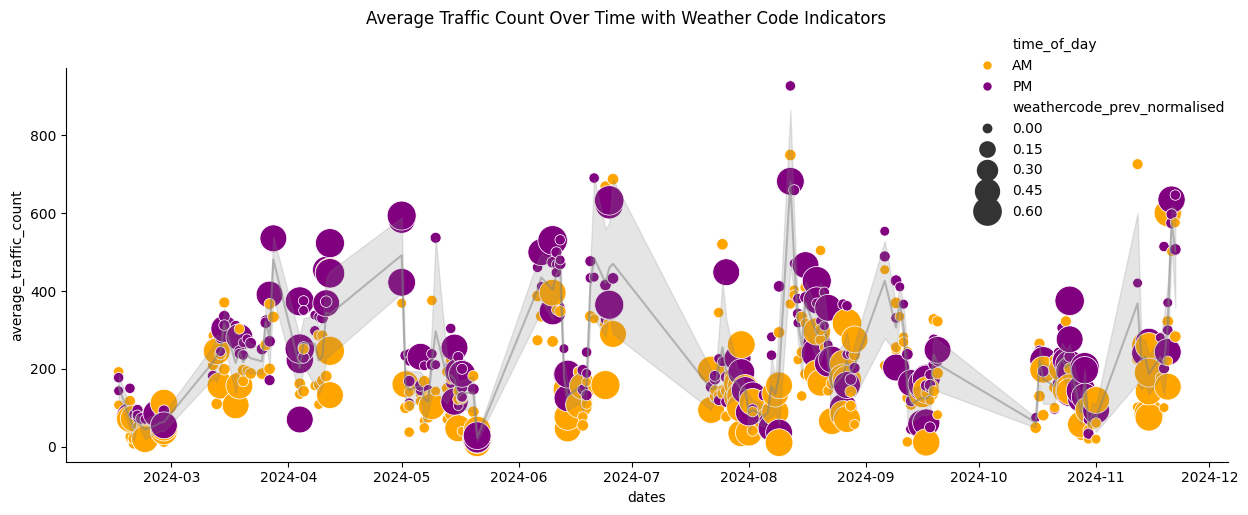

In [ ]:
## Plot weathercodes against traffic_count_agg over time, showing AM/PM

# Convert Spark DataFrame to Pandas DataFrame for plotting
pdf = weather_traffic_final.toPandas()

# Normalize weathercode_prev
MAX_CODE = 99.0
pdf["weathercode_prev_normalised"] = pdf["weathercode_prev"] / MAX_CODE

# Group by date, AM/PM, weathercode
agg_df = pdf.groupby(["dates", "time_of_day", "weathercode_prev_normalised"]).agg(
    average_traffic_count=('traffic_count', 'mean')
).reset_index()


# Sort by date for the plots
agg_df = agg_df.sort_values(by="dates")

# Create a scatter plot with lines
g = sns.relplot(
    data=agg_df,
    x="dates",
    y="average_traffic_count",
    hue="time_of_day",        # Colour by AM/PM period
    size="weathercode_prev_normalised", # Size by normalised weather code
    sizes=(50, 500),          # Define the range of marker sizes
    palette={"AM": "orange", "PM": "purple"}, # Specify colours for AM and PM
    height=5,
    aspect=2,
    facet_kws={'sharey': True, 'sharex': False} # Share y-axis, but not x-axis dates
)

# Add a line plot
g.map(sns.lineplot, "dates", "average_traffic_count", color='gray', alpha=0.5, legend=False) # Add a line plot


g.fig.suptitle("Average Traffic Count Over Time with Weather Code Indicators", y=1.02)
g.set_titles("")


# Adjust the legend's position inside the plot
g._legend.set_bbox_to_anchor((0.98, 0.98))  # position relative to axes
g._legend.set_loc("upper right")            # anchor point

plt.tight_layout()
plt.savefig("plot1_average_traffic_count_weather_indicators.png", dpi=250, bbox_inches="tight")
plt.show()

In [ ]:
# Check hours in (spark df) weather_traffic_final
weather_traffic_final.select("hour").distinct().show()

+----+
|hour|
+----+
|   6|
|  16|
|  17|
|   8|
|   7|
|  18|
+----+



In [ ]:
# Check distinct weathercode_desc in weather_traffic_final
weather_traffic_final.select("weathercode_desc_prev").distinct().show()

+---------------------+
|weathercode_desc_prev|
+---------------------+
|         Mainly clear|
|            Clear sky|
|        Partly cloudy|
|    Snow fall: slight|
|         Rain: slight|
|       Rain: moderate|
|       Drizzle: light|
|       Drizzle: dense|
|    Drizzle: moderate|
|             Overcast|
+---------------------+



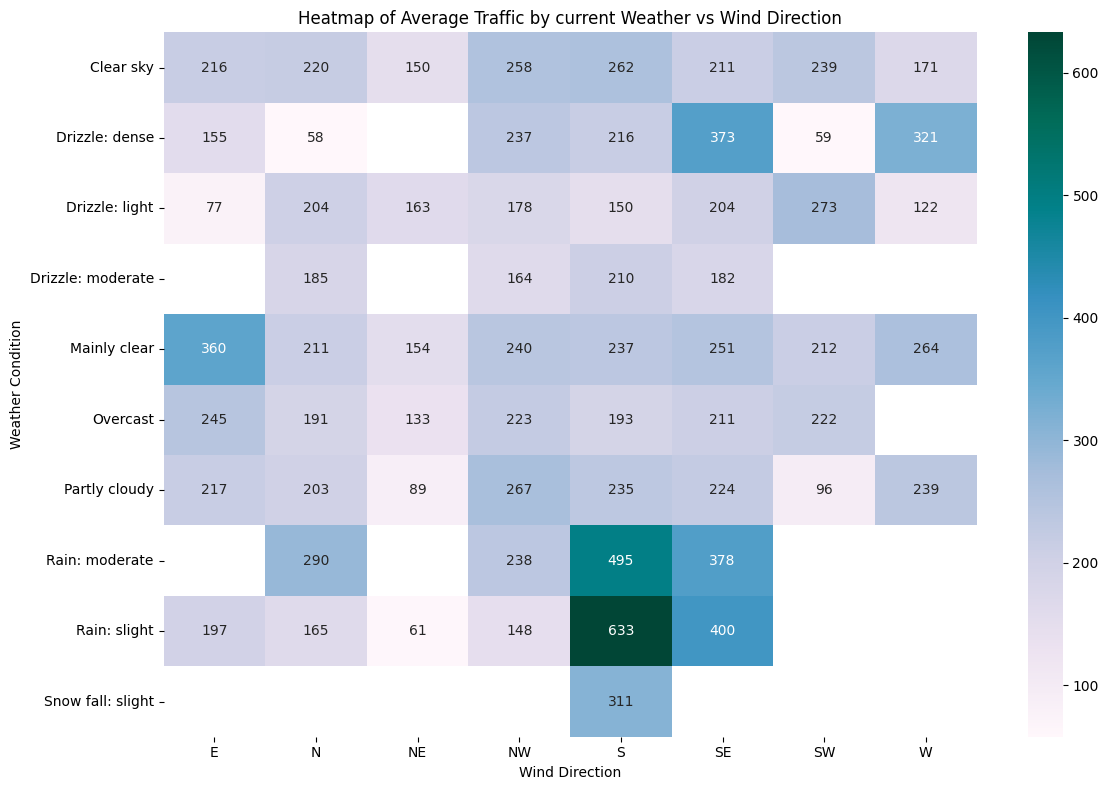

In [ ]:
## Plot categorical predictors vs target: Heatmap of current weather vs wind direction coloured by traffic count

# Aggregate mean traffic by weather × wind
agg = pdf.groupby(["weathercode_desc","wind_direction_desc"])["traffic_count"].mean().reset_index()

# Pivot to matrix
pivoted = agg.pivot(index="weathercode_desc", columns="wind_direction_desc", values="traffic_count")

plt.figure(figsize=(12,8))
sns.heatmap(pivoted, annot=True, fmt=".0f", cmap="PuBuGn")

plt.title("Heatmap of Average Traffic by current Weather vs Wind Direction")
plt.xlabel("Wind Direction")
plt.ylabel("Weather Condition")
plt.tight_layout()
plt.savefig("plot2_heatmap_current weather_winddir.png", dpi=250, bbox_inches="tight")
plt.show()

Comparing "current" (ie taken during the same hour as the traffic counts) weather to traffic, we can see slight-moderate rain + Southerly/SouthEasterly wind results in higher traffic counts. Similary, dense drizzle + SouthEasterly has an increased traffic count. This suggests that even with slight rain, road users prefer to drive if the wind is from the South, and even more inclined to do so if the rain density is moderate.
To a slightly lesser extent, we see a relationship between dense drizzle + Westerly wind.

In [ ]:
# Drop un-needed columns Date, Day_of_week from weather_traffic_final
weather_traffic_final = weather_traffic_final.drop("Date", "Holiday", "Day_of_week", "alt_id", "direction_label",
                             "temp", "sunshine", "rain", "windspeed", "gusts", "wind_direction", "weathercode" ,"weathercode_desc",
                             "wind_direction_desc","weekday"                       )

In [ ]:
weather_traffic_final.count()

14160

In [ ]:
weather_traffic_final.schema

StructType([StructField('dates', DateType(), True), StructField('hour', IntegerType(), True), StructField('zone', StringType(), True), StructField('site_id', LongType(), True), StructField('site_id_global', DoubleType(), True), StructField('site_code', StringType(), True), StructField('longitude', DoubleType(), True), StructField('latitude', DoubleType(), True), StructField('commute_direction', StringType(), True), StructField('time_of_day', StringType(), False), StructField('hour_bin', TimestampType(), True), StructField('traffic_count', LongType(), True), StructField('assignment_type', StringType(), False), StructField('temp_prev', DoubleType(), True), StructField('sunshine_prev', DoubleType(), True), StructField('rain_prev', DoubleType(), True), StructField('windspeed_prev', DoubleType(), True), StructField('gusts_prev', DoubleType(), True), StructField('wind_direction_prev', LongType(), True), StructField('weathercode_prev', LongType(), True), StructField('wind_direction_prev_desc'

## Visualise weather predictors vs traffic counts

The weathercodes we are using will be recoded to better reflect a severity scale, consistent with the World Meteorlogical Organization (WMO) weather codes.

In [ ]:
## Scale weather code for severity

# Global max code is 99 (WMO standard)
MAX_CODE = 99.0

weather_traffic_final = weather_traffic_final.withColumn(
    "weathercode_global",
    (F.col("weathercode_prev").cast("double") / F.lit(MAX_CODE))
)

In [ ]:
## remove _prev from remaining columns in weather_traffic_final
for col in weather_traffic_final.columns:
    if "_prev" in col:
        new_name = col.replace("_prev", "")
        weather_traffic_final = weather_traffic_final.withColumnRenamed(col, new_name)


In [ ]:
weather_traffic_final.printSchema()

root
 |-- dates: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- zone: string (nullable = true)
 |-- site_id: long (nullable = true)
 |-- site_id_global: double (nullable = true)
 |-- site_code: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- commute_direction: string (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- hour_bin: timestamp (nullable = true)
 |-- traffic_count: long (nullable = true)
 |-- assignment_type: string (nullable = false)
 |-- temp: double (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- gusts: double (nullable = true)
 |-- wind_direction: long (nullable = true)
 |-- weathercode: long (nullable = true)
 |-- wind_direction_desc: string (nullable = true)
 |-- weathercode_desc: string (nullable = true)
 |-- weathercode_global: double (nullable = true)



In [ ]:
## convert sunshine (seconds) into sunshine (minutes)
weather_traffic_final = weather_traffic_final.withColumn(
    "sunshine",
    F.col("sunshine") / F.lit(60)
)

Box plots for Commute Traffic vs Previous Hour's Weather Description:


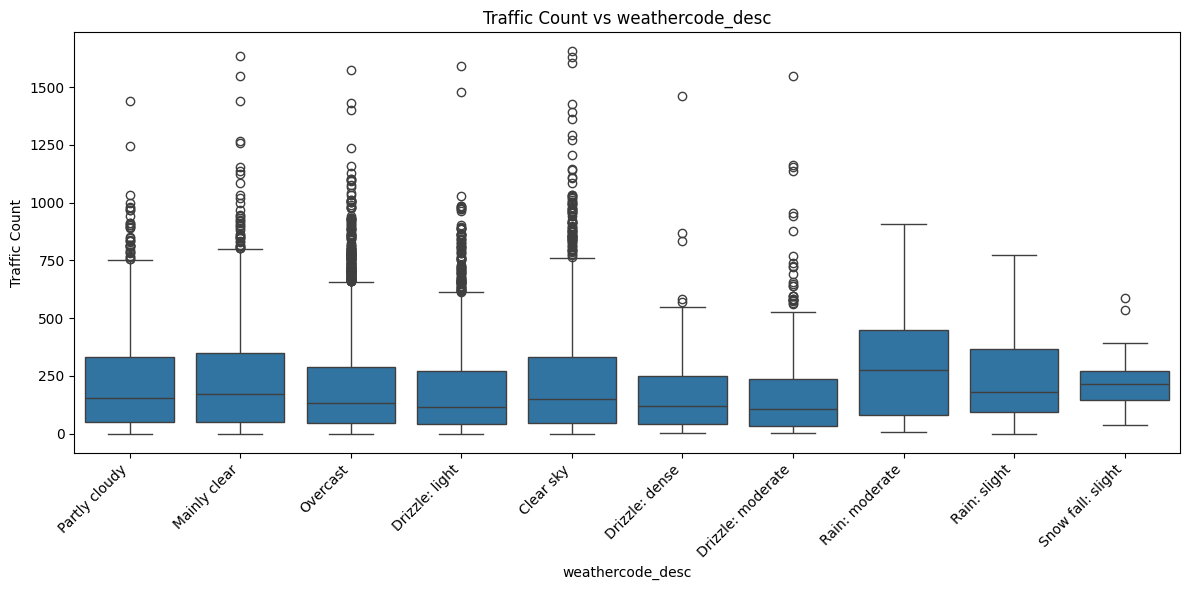

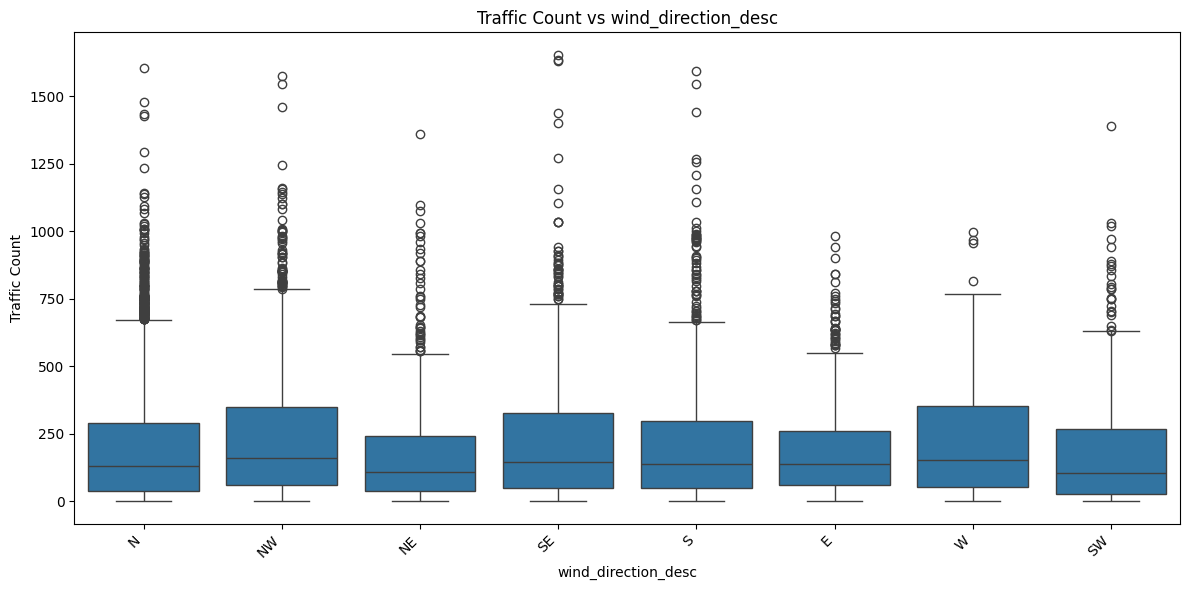

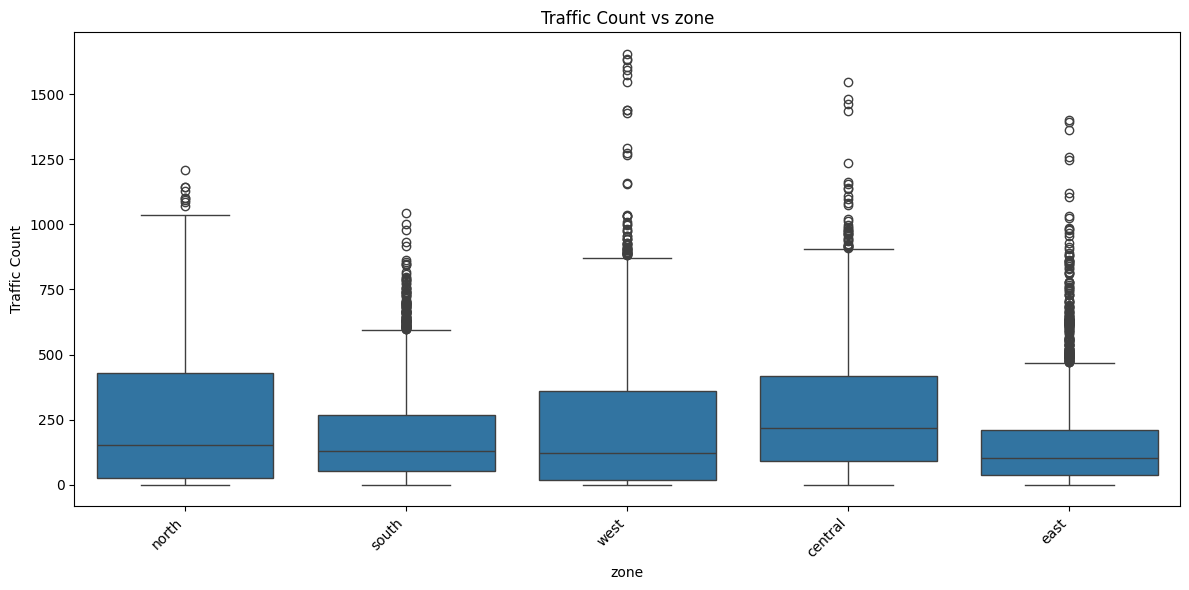

In [ ]:
## Plot categorical predictors vs target: Traffic vs weathercode, traffic vs wind direction

# Convert Spark DataFrame to Pandas DataFrame for plotting
weather_traffic_final_pdf = weather_traffic_final.toPandas()

# Define the target variable
target = "traffic_count"

# Define the categorical predictor variables (weather descriptions)
categorical_predictors = ["weathercode_desc", "wind_direction_desc","zone"]

# Create box plots
print("Box plots for Commute Traffic vs Previous Hour's Weather Description:")
for predictor in categorical_predictors:
    # Check if the predictor column exists in the Pandas DataFrame
    if predictor in weather_traffic_final_pdf.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=predictor, y=target, data=weather_traffic_final_pdf)
        plt.title(f"Traffic Count vs {predictor}")
        plt.xlabel(predictor)
        plt.ylabel("Traffic Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout() # Adjust layout to prevent labels from being cut off
        plt.savefig("boxplot_weathercode_and_winddir_desc_.png", dpi=250, bbox_inches="tight")
        plt.show()
    else:
        print(f"Plot3_Skipping box plot for missing column: {predictor}")

In [ ]:
weather_traffic_final_pdf.head()

dates  hour   zone  site_id  site_id_global    site_code   longitude  \
0  2024-07-25     7  north       64          1095.0  Glanmire Rd  174.821916   
1  2024-07-24    18  north       64          1095.0  Glanmire Rd  174.821916   
2  2024-03-22    17  south        2          1073.0  Adelaide Rd  174.775275   
3  2024-02-22    18  south       25          1078.0   Buckley Rd  174.782653   
4  2024-05-14     7   west       72          1097.0   Hohiria Rd  174.798645   

    latitude commute_direction time_of_day  ...  temp  sunshine rain  \
0 -41.227189               out          AM  ...  10.0    0.0000  0.0   
1 -41.227189               out          PM  ...  10.8   48.8155  0.0   
2 -41.320431               out          PM  ...  16.8   60.0000  0.0   
3 -41.331188               out          PM  ...  19.1   60.0000  0.0   
4 -41.300900                in          AM  ...   7.5    0.0000  0.0   

   windspeed  gusts  wind_direction  weathercode  wind_direction_desc  \
0       21.7   44.3               6            2                    N   
1        9.3   18.7             344            1                    N   
2       12.7   32.0             331            3                   NW   
3       11.2   31.3             354            3                    N   
4        6.5   14.0              34            3                   NE   

   weathercode_desc  weathercode_global  
0     Partly cloudy            0.020202  
1      Mainly clear            0.010101  
2          Overcast            0.030303  
3          Overcast            0.030303  
4          Overcast            0.030303  

[5 rows x 23 columns]

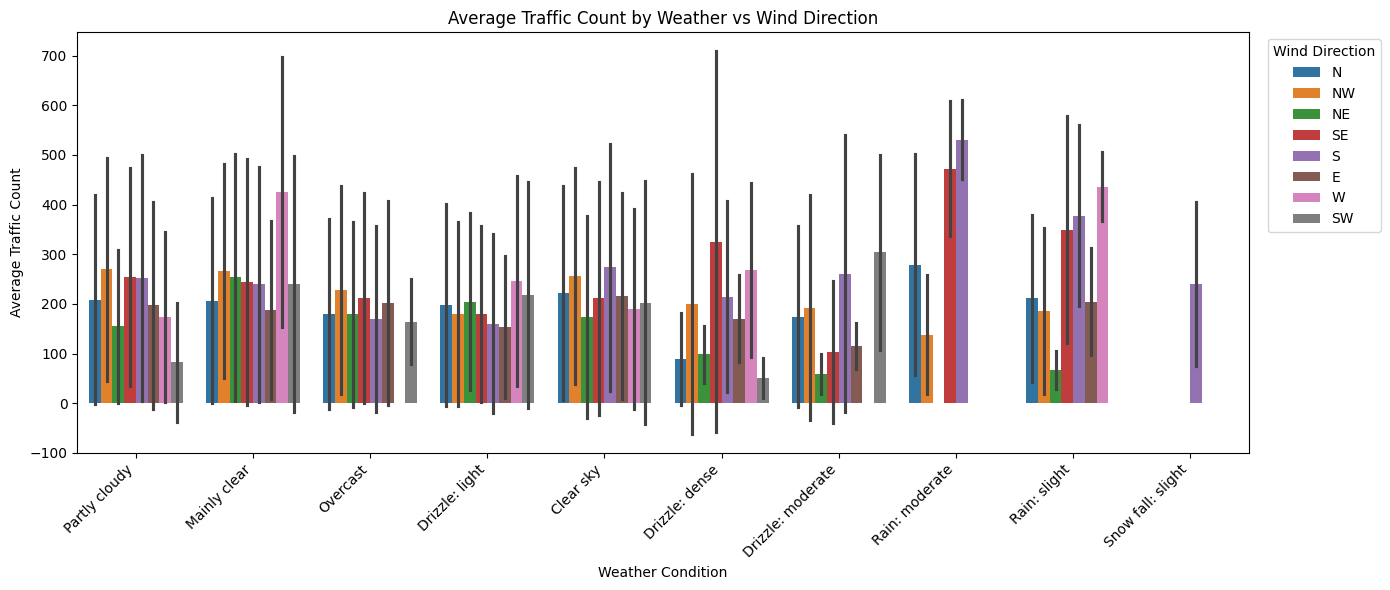

In [ ]:
## Plot categorical predictors vs target: Weathercode vs Wind direction vs traffic count

# Convert Spark DataFrame to Pandas DataFrame for plotting
pdf = weather_traffic_final.toPandas()

plt.figure(figsize=(14,6))
sns.barplot(
    data=pdf,
    x="weathercode_desc",
    y="traffic_count",
    hue="wind_direction_desc",
    estimator="mean",
    errorbar="sd"
)

plt.title("Average Traffic Count by Weather vs Wind Direction")
plt.xlabel("Weather Condition")
plt.ylabel("Average Traffic Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Wind Direction", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.savefig("plot6_average_traffic_by_weather_winddir_.png", dpi=250, bbox_inches="tight")
plt.show()

Considering the influence of weather from the previous hour on current traffic, we can see that a strong relationship between Slight rain + SouthWesterly wind direction. Slight rain + Southerly wind direction have a wide standard deviation, perhaps indicating that certain drivers might still take unsheltered transport (foot, bike etc) despite a South "flavoured" wind, if the rain intensity is only "slight".
Moderate rain and Southerly wind direction contribute to the second highest traffic count.
Traffic counts for Northerly winds tend to be slightly lower - Northerly winds are often warmer, and may not be a significant detractor for unsheltered modes of transports.

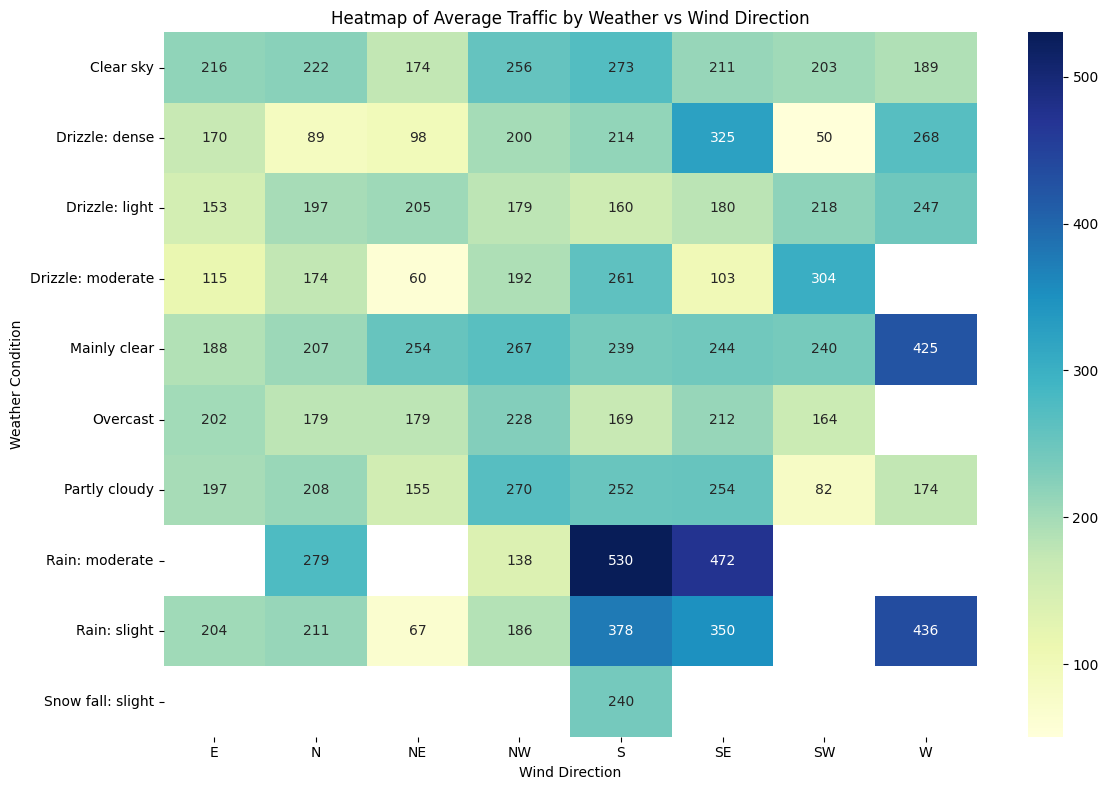

In [ ]:
## Plot categorical predictors vs target: Heatmap of weather vs wind direction coloured by traffic count

pdf = weather_traffic_final_pdf

# Aggregate mean traffic by weather × wind
agg = pdf.groupby(["weathercode_desc","wind_direction_desc"])["traffic_count"].mean().reset_index()

# Pivot to matrix
pivoted = agg.pivot(index="weathercode_desc", columns="wind_direction_desc", values="traffic_count")

plt.figure(figsize=(12,8))
sns.heatmap(pivoted, annot=True, fmt=".0f", cmap="YlGnBu", mask=pivoted.isnull())

plt.title("Heatmap of Average Traffic by Weather vs Wind Direction")
plt.xlabel("Wind Direction")
plt.ylabel("Weather Condition")
plt.tight_layout()
plt.savefig("plot7_heatmap_previousweather_winddir_.png", dpi=250, bbox_inches="tight")
plt.show()

For weather measured in the previous hour, we can see drivers have considered moderate rain together with Southerly wind in opting to drive. Surprisingly, the combination of *slight* rain with SouthWesterly wind results in a higher traffic count than moderate rain and a direct Southerly.

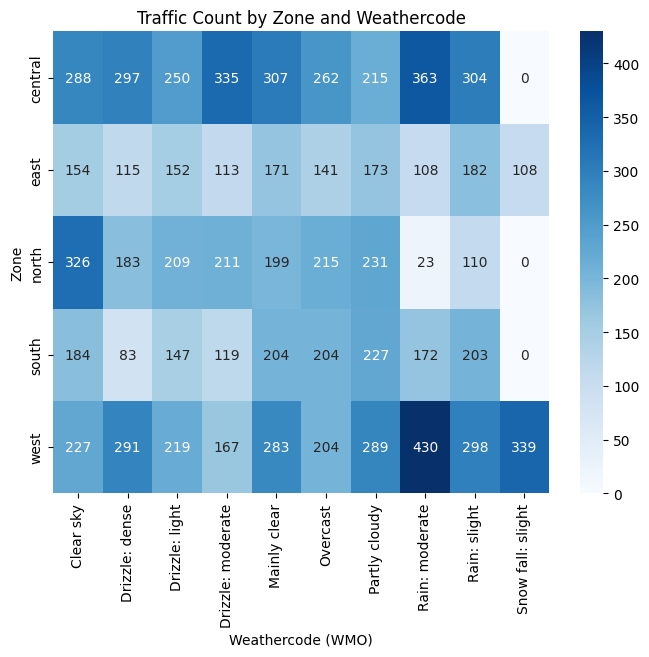

In [ ]:
## Heatmap time of day, zones, traffic_count

pdf = weather_traffic_final_pdf

# Pivot the data so rows = zones, columns = weathercode descriptions, values = traffic_count
heatmap_data = (
    pdf
    .groupby(["zone", "weathercode_desc"])["traffic_count"]
    .mean()   # or sum, depending on what you want
    .unstack(fill_value=0)
)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="Blues"   # gradient colormap
)
plt.title("Traffic Count by Zone and Weathercode")
plt.ylabel("Zone")
plt.xlabel("Weathercode (WMO)")
plt.savefig("plot8_heatmap_zones_weathercode_.png", dpi=250, bbox_inches="tight")
plt.show()

Box plot of traffic_count by weathercode_desc faceted by hour:


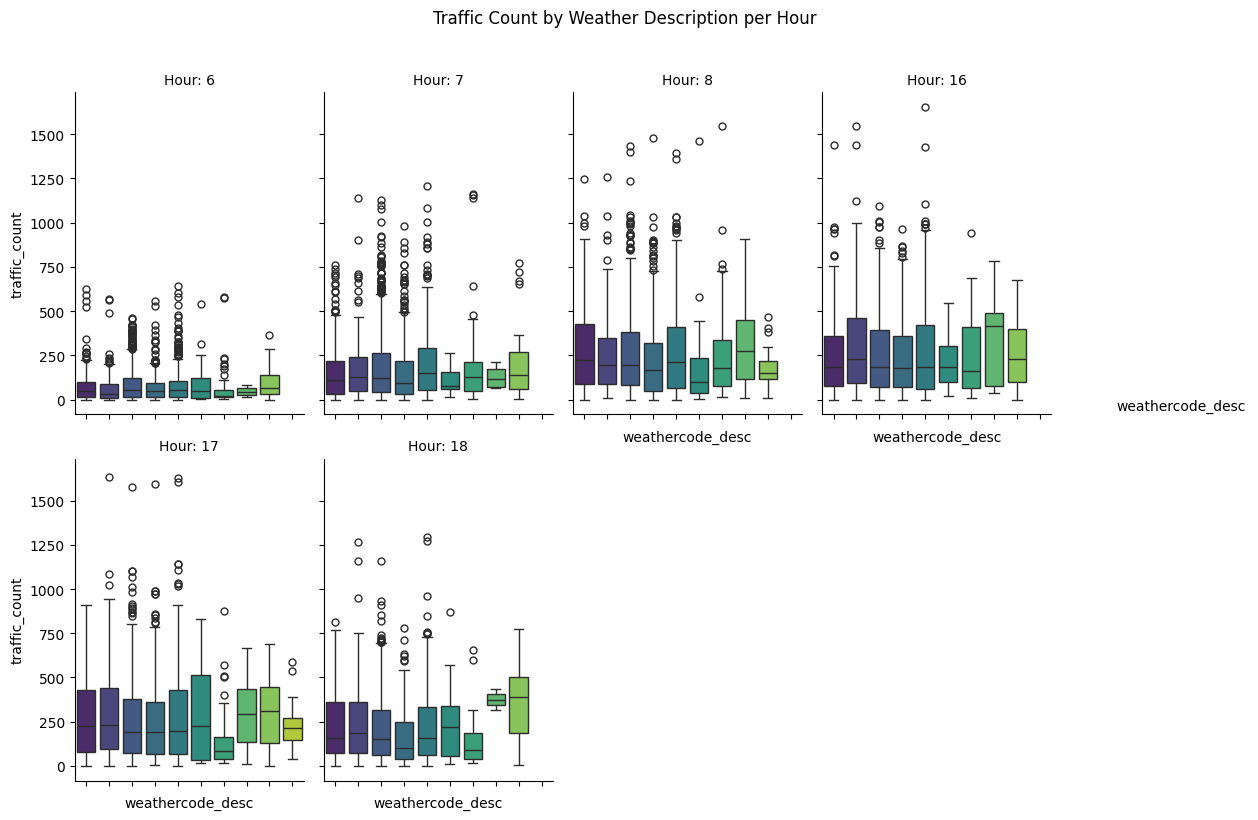

In [ ]:
# Box plot of Traffic Count by Weather Description (faceted by Hour)

# Convert Spark DataFrame to Pandas DataFrame for plotting (if not already done)
if 'weather_traffic_final_pdf' not in locals():
    weather_traffic_final_pdf = weather_traffic_final.toPandas()

# Define the target and predictor variables
target = "traffic_count"
weather_predictor = "weathercode_desc" # Changed back to weathercode_desc_prev
hour_facet = "hour"

print(f"Box plot of {target} by {weather_predictor} faceted by {hour_facet}:")

# Create the box plot with faceting and consistent colours/legend
g = sns.catplot(
    x=weather_predictor,
    y=target,
    col=hour_facet,
    data=weather_traffic_final_pdf,
    kind="box",
    col_wrap=4,
    height=4,
    aspect=.7,
    hue=weather_predictor,  # Use weather_predictor for colouring
    palette="viridis",
    legend_out=True # Place the legend outside the plots to the right
)
g.fig.suptitle(f'Traffic Count by Weather Description per Hour', y=1.02) # Add a title to the figure
g.set_titles("Hour: {col_name}") # Set titles for each subplot
g.set_xticklabels(rotation=45, ha="right") # Rotate x-axis labels for readability

# Add the legend explicitly and adjust layout to make space for it
g.add_legend(title=weather_predictor)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust the rectangle to leave space on the right for the legend
plt.savefig("plot9_colourweathercode_desc_.png", dpi=250, bbox_inches="tight")

plt.show()

Metrics relating to snow fall in Wellington are highly unusual; outside higher elevations, it has not snowed in Wellington since August 2022.
Early commuters prefer to drive rather than face further freezing drizzle if it had occurred in the hour before they set off, especially when it fell densely.
Traffic counts rise overall between 6:00am and 8:00am in the morning rush.
From 4:00pm to 6:00pm, the traffic counts are steady, dropping slightly in the hour from 6:00pm-7:00pm.
Moderate rain in the 8:00am-9:00am and 4:00pm-5:00pm windows had the highest mean traffic counts for those periods.
From 6:00am-9:00am and 5:00pm to 7:00pm there are no traffic counts against the "Unknown" weather condition.


In [ ]:
# When did it snow in 2024?
weather_traffic_final.filter(F.col("weathercode_desc") == "Snow fall: slight").show()

+----------+----+----+-------+--------------+--------------+------------------+------------------+-----------------+-----------+-------------------+-------------+---------------+----+--------+----+---------+-----+--------------+-----------+-------------------+-----------------+------------------+
|     dates|hour|zone|site_id|site_id_global|     site_code|         longitude|          latitude|commute_direction|time_of_day|           hour_bin|traffic_count|assignment_type|temp|sunshine|rain|windspeed|gusts|wind_direction|weathercode|wind_direction_desc| weathercode_desc|weathercode_global|
+----------+----+----+-------+--------------+--------------+------------------+------------------+-----------------+-----------+-------------------+-------------+---------------+----+--------+----+---------+-----+--------------+-----------+-------------------+-----------------+------------------+
|2024-08-19|  17|east|    193|           NaN|       Tacy St| 174.7981148470147|-41.31681545443904|        

In [ ]:
weather_traffic_final_pdf.shape

(14160, 23)

Box plot of traffic_count by wind_direction_desc faceted by time_of_day:


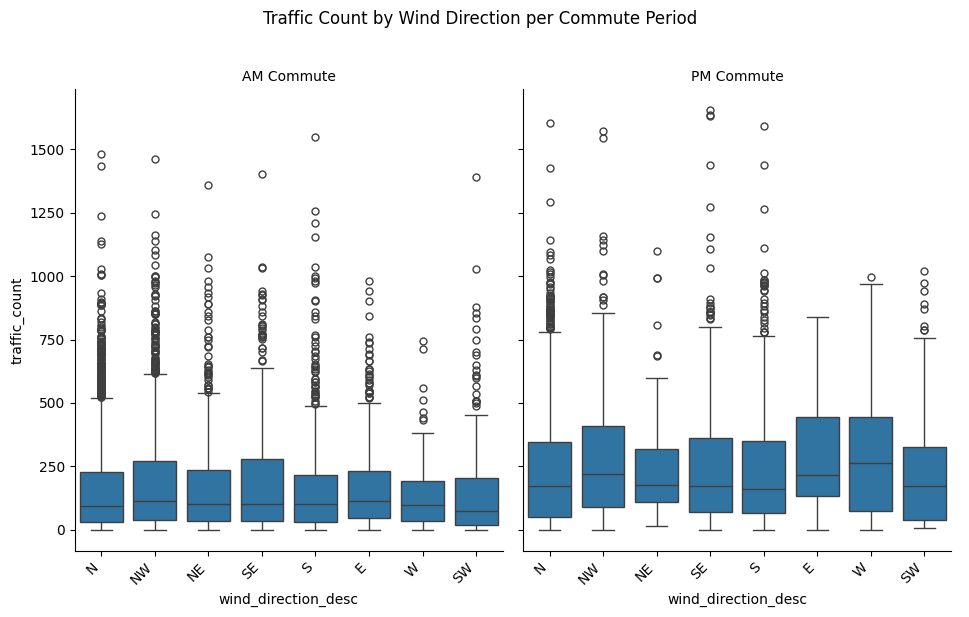

In [ ]:
# Box plot of Traffic Count by Wind Direction Description (faceted by AM/PM)

# Convert Spark DataFrame to Pandas DataFrame for plotting (if not already done)
if 'weather_traffic_final_pdf' not in locals():
    weather_traffic_final_pdf = weather_traffic_final.toPandas()

# Define the target and predictor variables
target = "traffic_count"
wind_predictor = "wind_direction_desc"
commuteperiod_facet = "time_of_day"

print(f"Box plot of {target} by {wind_predictor} faceted by {commuteperiod_facet}:")

# Create the box plot with faceting
g = sns.catplot(
    x=wind_predictor,
    y=target,
    col=commuteperiod_facet,
    data=weather_traffic_final_pdf,
    kind="box",
    height=6,
    aspect=.8
)
g.fig.suptitle(f'Traffic Count by Wind Direction per Commute Period', y=1.02)
g.set_titles("{col_name} Commute") # Set titles for each subplot
g.set_xticklabels(rotation=45, ha="right") # Rotate x-axis labels for readability

plt.tight_layout()
plt.savefig("plot10_winddirection by AM-PM_.png", dpi=250, bbox_inches="tight")
plt.show()

## Feature Engineering, Prepare data for modelling, visualise data

Scatter plots for Traffic Count vs Predictors:


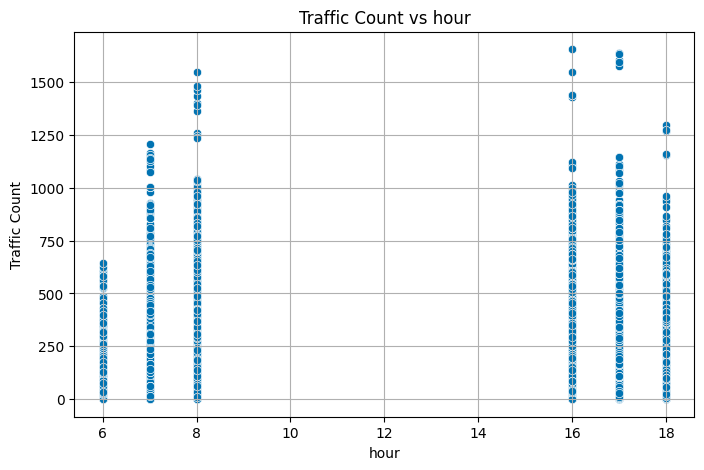

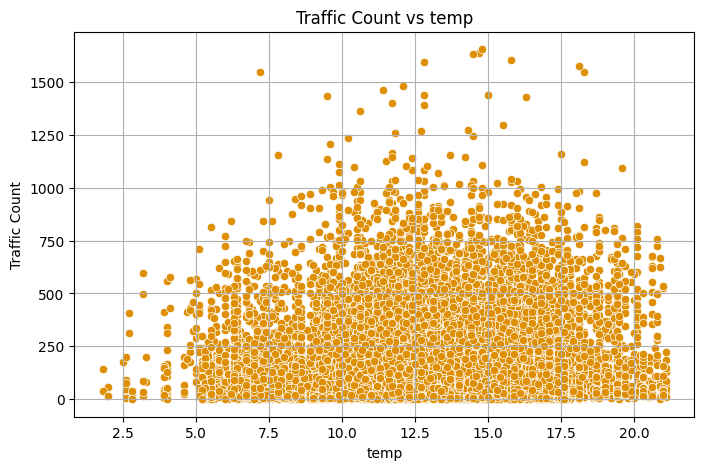

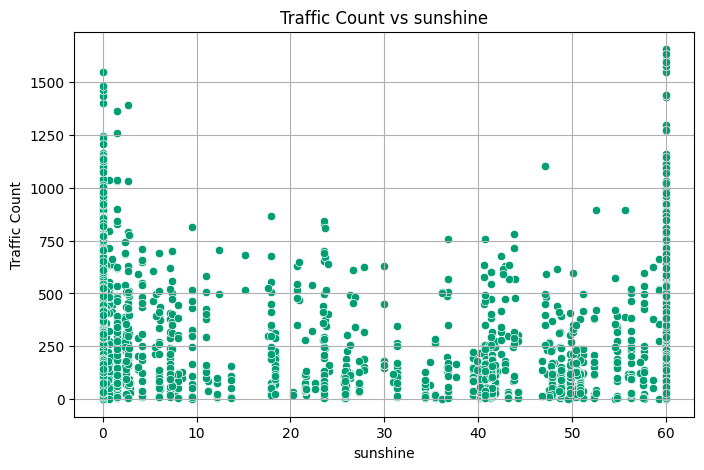

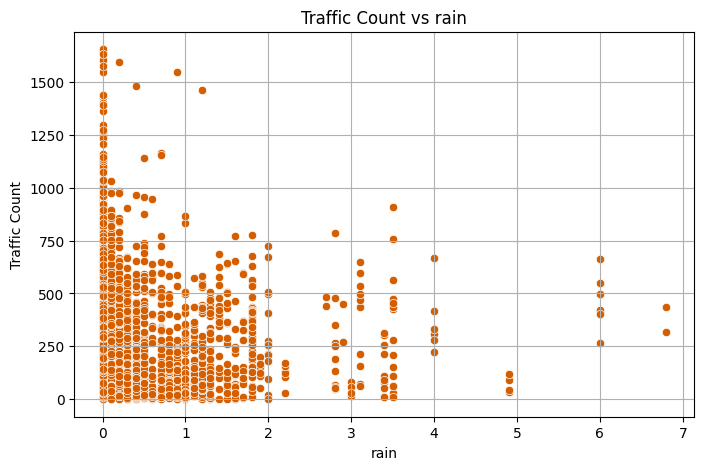

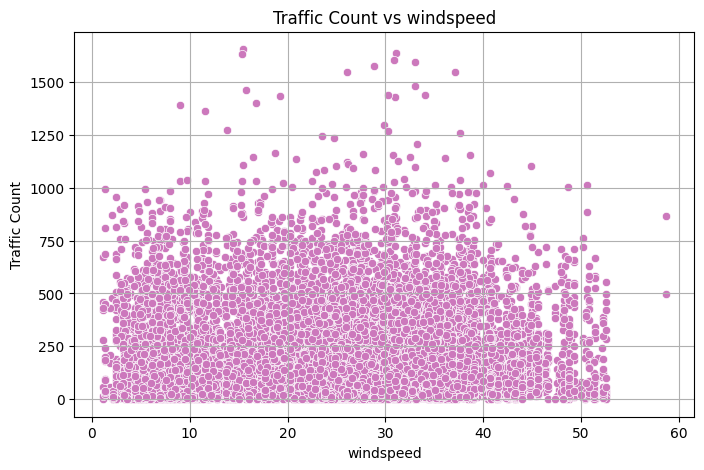

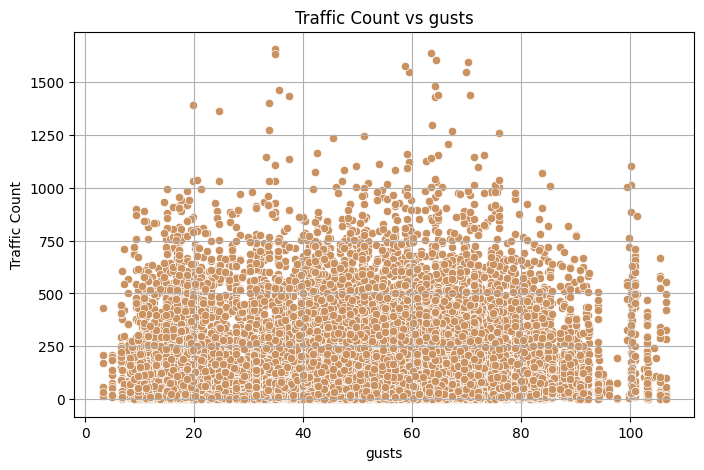

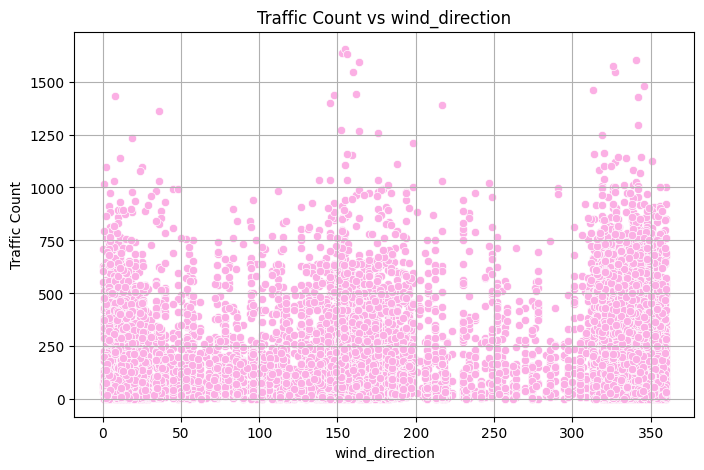

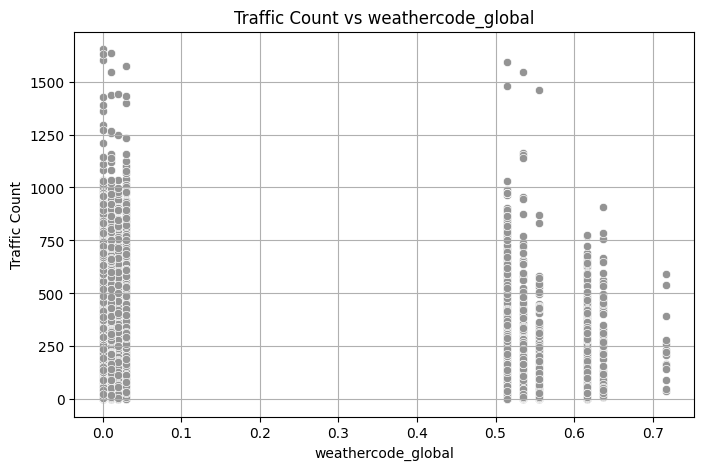

In [ ]:
## Scatterplots of target vs predictor variables

# Convert Spark DataFrame to Pandas DataFrame for plotting
weather_traffic_final_pdf = weather_traffic_final.toPandas()

# Define the target variable
target = "traffic_count"

# Define the predictor variables (weather metrics)
predictors = [
    "hour", # Add hour to predictors
    "temp", "sunshine", "rain",
    "windspeed", "gusts",
    "wind_direction",
    "weathercode_global" # Added weathercode_global
]

# Define Okabe-Ito palette
okabe_ito_palette = sns.color_palette("colorblind")

# Create scatter plots
print("Scatter plots for Traffic Count vs Predictors:")
for i, predictor in enumerate(predictors):
    # Check if the predictor column exists and is numeric in the Pandas DataFrame
    if predictor in weather_traffic_final_pdf.columns and pd.api.types.is_numeric_dtype(weather_traffic_final_pdf[predictor]):
        plt.figure(figsize=(8, 5))
        # Use a colour from the Okabe-Ito palette, cycling through them
        scatter_color = okabe_ito_palette[i % len(okabe_ito_palette)]
        sns.scatterplot(x=predictor, y=target, data=weather_traffic_final_pdf, color=scatter_color)
        plt.title(f"Traffic Count vs {predictor}")
        plt.xlabel(predictor)
        plt.ylabel("Traffic Count")
        plt.grid(True)
        plt.savefig(f"scatterplot_{predictor}_.png", dpi=300, bbox_inches="tight")
        plt.show()
    else:
        print(f"plot11_Skipping scatter plot for non-numeric or missing column: {predictor}")

In [ ]:
# Drop weathercode_desc
weather_traffic_final = weather_traffic_final.drop("weathercode_desc")

In [ ]:
## Encoding predictors

# 1. Hour bucketing (6=1,7=2,8=3,16=1,17=2,18=3)
# Map only commute hours, leave others as null or 0
hour_map = F.create_map(
    [F.lit(6), F.lit(1),
     F.lit(7), F.lit(2),
     F.lit(8), F.lit(3),
     F.lit(16), F.lit(1),
     F.lit(17), F.lit(2),
     F.lit(18), F.lit(3)]
)

df = weather_traffic_final.withColumn("hour_of_peak", hour_map[F.col("hour")].cast(IntegerType()))

# 2. Time of day (AM=1, PM=0)
df = df.withColumn("time_binary", F.when(F.col("time_of_day") == "AM", F.lit(1)).otherwise(F.lit(0)))

# 3. Commute direction (in=1, out=0)
df = df.withColumn("move_centrally",
                   F.when(F.col("commute_direction") == "in", F.lit(1)).otherwise(F.lit(0)))

# 4. Dates → DateType + seasonal flags
df = df.withColumn("dates", F.col("dates").cast(DateType()))
df = df.withColumn("month", F.month("dates"))

df = (df
    .withColumn("is_spring", F.when(F.col("month").isin([9,10,11]), 1).otherwise(0))
    .withColumn("is_summer", F.when(F.col("month").isin([12,1,2]), 1).otherwise(0))
    .withColumn("is_autumn", F.when(F.col("month").isin([3,4,5]), 1).otherwise(0))
    .withColumn("is_winter", F.when(F.col("month").isin([6,7,8]), 1).otherwise(0))
)

In [ ]:
df.printSchema()

root
 |-- dates: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- zone: string (nullable = true)
 |-- site_id: long (nullable = true)
 |-- site_id_global: double (nullable = true)
 |-- site_code: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- commute_direction: string (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- hour_bin: timestamp (nullable = true)
 |-- traffic_count: long (nullable = true)
 |-- assignment_type: string (nullable = false)
 |-- temp: double (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- gusts: double (nullable = true)
 |-- wind_direction: long (nullable = true)
 |-- weathercode: long (nullable = true)
 |-- wind_direction_desc: string (nullable = true)
 |-- weathercode_global: double (nullable = true)
 |-- hour_of_peak: integer (nullable = true)
 |-- time_binary: integer (nullabl

In [ ]:
# Folium plot of traffic counts per zone, sized by traffic_count, coloured by season

# Aggregate traffic counts by zone and season
traffic_by_zone_season = df.groupBy("zone", "is_spring", "is_summer", "is_autumn", "is_winter").agg(
    F.avg("traffic_count").alias("average_traffic_count"),
    F.avg("latitude").alias("avg_latitude"), # Get average lat/lon for marker placement
    F.avg("longitude").alias("avg_longitude")
)

# Determine the season name based on the season flags
traffic_by_zone_season = traffic_by_zone_season.withColumn(
    "season",
    F.when(F.col("is_spring") == 1, "Spring")
     .when(F.col("is_summer") == 1, "Summer")
     .when(F.col("is_autumn") == 1, "Autumn")
     .when(F.col("is_winter") == 1, "Winter")
)

# Convert to Pandas DataFrame for Folium plotting
traffic_by_zone_season_pdf = traffic_by_zone_season.toPandas()

# Create a base map
m = folium.Map(location=[-41.2865, 174.7762], zoom_start=12)

# Define a colour map for seasons (colourblind friendly)
season_colours = {
    "Spring": "green",
    "Summer": "orange",
    "Autumn": "red",
    "Winter": "blue"
}

# Add circles for each zone, sized by average traffic and coloured by season
for index, row in traffic_by_zone_season_pdf.iterrows():
    folium.CircleMarker(
        location=[row['avg_latitude'], row['avg_longitude']],
        radius=row['average_traffic_count'] / 20, # Adjust scaling factor as needed
        color=season_colours.get(row['season'], 'gray'), # Get colour from map, default to gray
        fill=True,
        fill_color=season_colours.get(row['season'], 'gray'),
        fill_opacity=0.7,
        popup=f"Zone: {row['zone']}<br>Season: {row['season']}<br>Avg Traffic: {row['average_traffic_count']:.2f}"
    ).add_to(m)

# Add a legend (Folium doesn't have an automatic legend for CircleMarkers)
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 150px; height: 100px;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 ">&nbsp; <b>Average Traffic by Season</b> <br>
                 &nbsp; Spring &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
                 &nbsp; Summer &nbsp; <i class="fa fa-circle" style="color:orange"></i><br>
                 &nbsp; Autumn &nbsp; <i class="fa fa-circle" style="color:red"></i><br>
                 &nbsp; Winter &nbsp; <i class="fa fa-circle" style="color:blue"></i>
      </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))


# Display the map
m

In [ ]:
# drop unneeded columns
df_model = df.drop("dates","hour","site_id","site_id_global","site_code","longitude","latitude","commute_direction","time_of_day","month","weathercode","weather_desc","weathercode_desc","hour_bin")

In [ ]:
df_model.printSchema()

root
 |-- zone: string (nullable = true)
 |-- traffic_count: long (nullable = true)
 |-- assignment_type: string (nullable = false)
 |-- temp: double (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- gusts: double (nullable = true)
 |-- wind_direction: long (nullable = true)
 |-- wind_direction_desc: string (nullable = true)
 |-- weathercode_global: double (nullable = true)
 |-- hour_of_peak: integer (nullable = true)
 |-- time_binary: integer (nullable = false)
 |-- move_centrally: integer (nullable = false)
 |-- is_spring: integer (nullable = false)
 |-- is_summer: integer (nullable = false)
 |-- is_autumn: integer (nullable = false)
 |-- is_winter: integer (nullable = false)



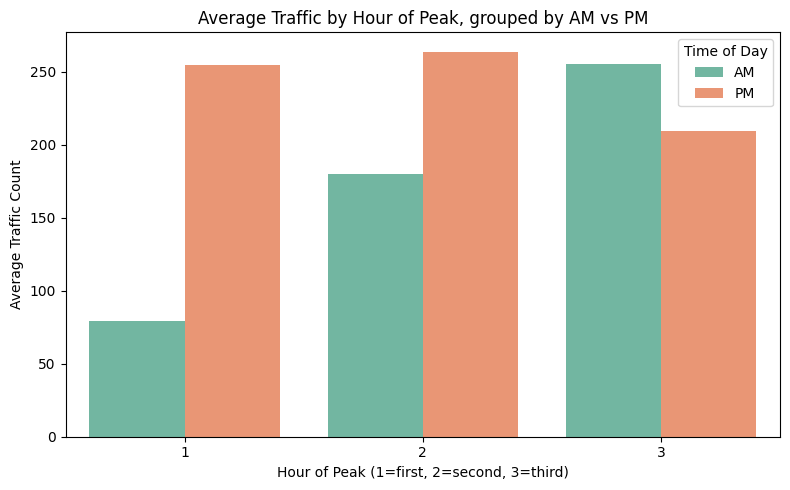

In [ ]:
## Grouped bar plot: hour of peak vs time of day (avg traffic counts coloured by AM/PM)

# Convert Spark DataFrame to Pandas for plotting
pdf = df_model.toPandas()

# Map time_binary for readability
pdf["time_of_day"] = pdf["time_binary"].map({1: "AM", 0: "PM"})

# Aggregate mean traffic by hour_of_peak × time_of_day
agg = pdf.groupby(["hour_of_peak","time_of_day"])["traffic_count"].mean().reset_index()

# Plot grouped bar
plt.figure(figsize=(8,5))
sns.barplot(data=agg, x="hour_of_peak", y="traffic_count", hue="time_of_day", palette="Set2")

plt.title("Average Traffic by Hour of Peak, grouped by AM vs PM")
plt.xlabel("Hour of Peak (1=first, 2=second, 3=third)")
plt.ylabel("Average Traffic Count")
plt.legend(title="Time of Day")
plt.tight_layout()
plt.savefig("plot20_average_traffic_by_hourpeak_timeofday_.png", dpi=250, bbox_inches="tight")
plt.show()

/tmp/ipython-input-811374790.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = pdf.groupby(["season","time_binary"])["traffic_count"].mean().reset_index()


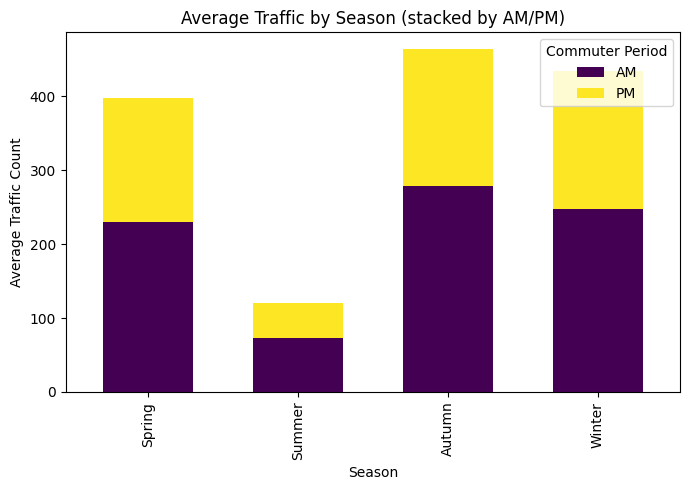

In [ ]:
## Stacked Bar Plot: Traffic by Season vs AM/PM


# Melt seasonal dummies into a single "season" column
season_cols = ["is_spring","is_summer","is_autumn","is_winter"]
pdf = pdf.melt(id_vars=["traffic_count","time_binary"],
               value_vars=season_cols,
               var_name="season", value_name="flag")

# Keep only rows where flag=1
pdf = pdf[pdf["flag"]==1]

# Map season names for readability
pdf["season"] = pdf["season"].map({
    "is_spring":"Spring",
    "is_summer":"Summer",
    "is_autumn":"Autumn",
    "is_winter":"Winter"
})

# Define chronological order
season_order = ["Spring", "Summer", "Autumn", "Winter"]

# Make season a categorical with that order
pdf["season"] = pd.Categorical(pdf["season"], categories=season_order, ordered=True)

# Aggregate mean traffic by season vs time_binary(AM/PM)
agg = pdf.groupby(["season","time_binary"])["traffic_count"].mean().reset_index()

# Plot stacked bar
pivoted = agg.pivot(index="season", columns="time_binary", values="traffic_count")
pivoted.plot(kind="bar", stacked=True, width=0.6, figsize=(7,5), colormap="viridis")

plt.title("Average Traffic by Season (stacked by AM/PM)")
plt.ylabel("Average Traffic Count")
plt.xlabel("Season")
plt.legend(title="Commuter Period", labels=["AM","PM"])
plt.tight_layout()
plt.savefig("plot21_average_traffic_by_season_vs_AM-PM_.png", dpi=250, bbox_inches="tight")
plt.show()

In [ ]:
df_model.show()

+-------+-------------+---------------+----+------------------+----+---------+-----+--------------+-------------------+--------------------+------------+-----------+--------------+---------+---------+---------+---------+
|   zone|traffic_count|assignment_type|temp|          sunshine|rain|windspeed|gusts|wind_direction|wind_direction_desc|  weathercode_global|hour_of_peak|time_binary|move_centrally|is_spring|is_summer|is_autumn|is_winter|
+-------+-------------+---------------+----+------------------+----+---------+-----+--------------+-------------------+--------------------+------------+-----------+--------------+---------+---------+---------+---------+
|  north|          156|         direct|10.0|               0.0| 0.0|     21.7| 44.3|             6|                  N|0.020202020202020204|           2|          1|             0|        0|        0|        0|        1|
|  north|           53|         direct|10.8|           48.8155| 0.0|      9.3| 18.7|           344|                 

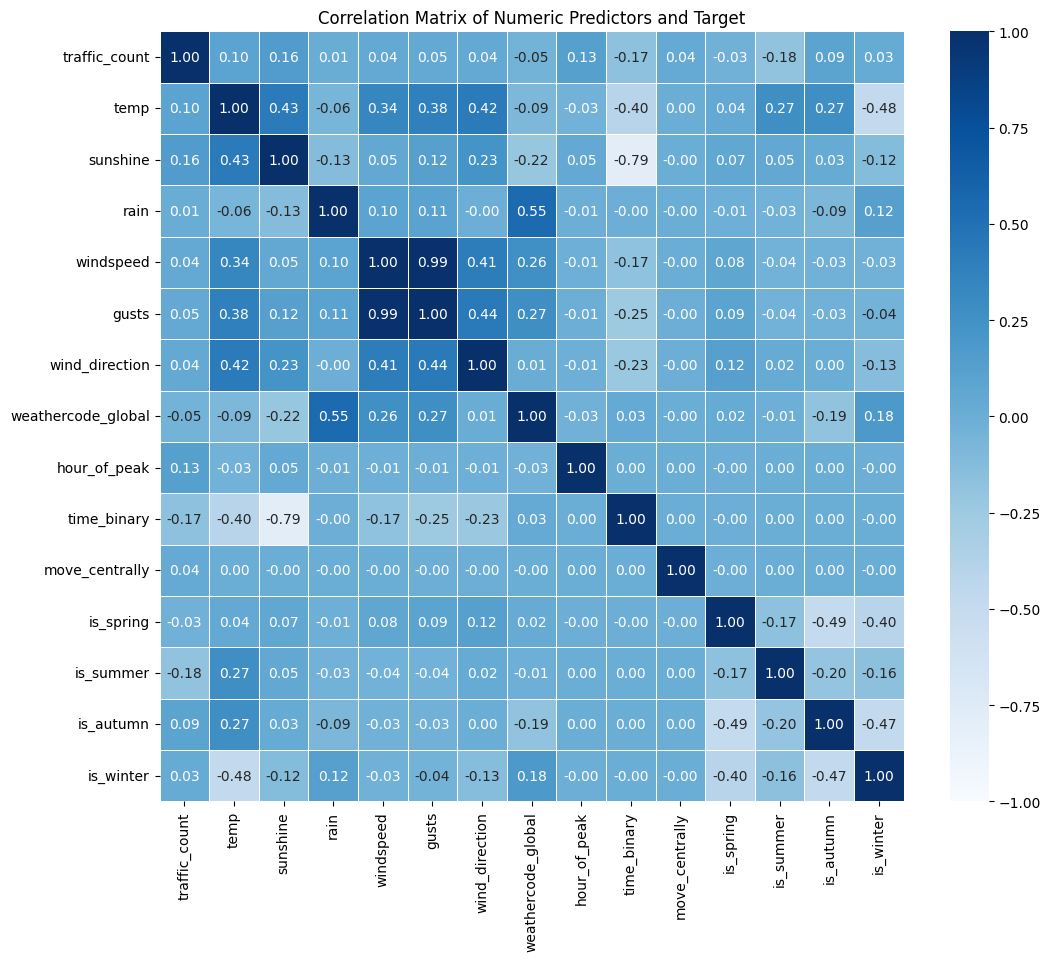

In [ ]:
## Correlation matrix of curated predictors

# Convert Spark DataFrame to Pandas DataFrame for plotting
pdf = df_model.toPandas()


# Select only numeric columns for the correlation matrix
numeric_cols = pdf.select_dtypes(include=np.number).columns.tolist()
df_model_numeric_pdf = pdf[numeric_cols]

# Compute the correlation matrix
correlation_matrix = df_model_numeric_pdf.corr()

# Plot the correlation matrix as a heatmap with a gradient
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="Blues",       # gradient colormap
    fmt=".2f",
    linewidths=.5,
    vmin=-1, vmax=1     # ensures consistent scale across correlations
)
plt.title("Correlation Matrix of Numeric Predictors and Target")
plt.savefig("plot23_correlation_matrix_blues.png", dpi=250, bbox_inches="tight")
plt.show()


Given windspeed and gusts (both measured at a height of 10 meters) correlate closely, we need to understand if there is enough variation between these two metrics to justify keeping them. "Gusts" can trigger weather warning against vehicle use.
The relationship between rain_prev and weathercode_global is explained by rain being a coded value under weathercode_global.

In [ ]:
## compare windspeed and gusts min, max, mean, mode in weather_traffic_final


# Min, Max, Mean
stats = (df_model
         .agg(
             F.min("windspeed").alias("windspeed_min"),
             F.max("windspeed").alias("windspeed_max"),
             F.mean("windspeed").alias("windspeed_mean"),
             F.min("gusts").alias("gusts_min"),
             F.max("gusts").alias("gusts_max"),
             F.mean("gusts").alias("gusts_mean")
         ))

stats.show()

# Mode (most frequent value) for each column
windspeed_mode = (weather_traffic_final
                  .groupBy("windspeed")
                  .count()
                  .orderBy(F.desc("count"))
                  .first())

gusts_mode = (weather_traffic_final
              .groupBy("gusts")
              .count()
              .orderBy(F.desc("count"))
              .first())

print("Windspeed mode:", windspeed_mode)
print("Gusts mode:", gusts_mode)

+-------------+-------------+----------------+---------+---------+------------------+
|windspeed_min|windspeed_max|  windspeed_mean|gusts_min|gusts_max|        gusts_mean|
+-------------+-------------+----------------+---------+---------+------------------+
|          1.1|         58.7|23.8801694915253|      3.2|    106.6|49.528149717513884|
+-------------+-------------+----------------+---------+---------+------------------+

Windspeed mode: Row(windspeed=20.3, count=140)
Gusts mode: Row(gusts=48.6, count=180)


Considering the differences between max windspeed and max gusts, we will retain both columns and visualise windspeed vs gusts to check and confirm the above stats. Interpretation instructions:
- Points above the red line = gusts stronger than sustained wind (expected)
- Points close to the line = gusts ≈ windspeed (less variability)
- Outliers far above the line = extreme wind gusts measured

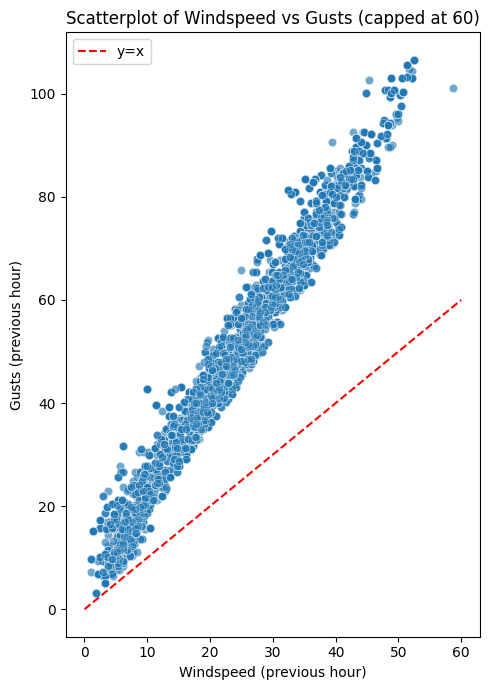

In [ ]:
## Visual check/confirmation: Windspeed vs Gusts

plt.figure(figsize=(5,7))
sns.scatterplot(data=pdf, x="windspeed", y="gusts", alpha=0.4)

# Add 1:1 reference line
max_val = 60
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--", label="y=x")

# Limit axes
#plt.xlim(0, 60) # plotted points do not exceed x=60

plt.title("Scatterplot of Windspeed vs Gusts (capped at 60)")
plt.xlabel("Windspeed (previous hour)")
plt.ylabel("Gusts (previous hour)")
plt.legend()
plt.tight_layout()
plt.savefig("plot24_scatterplot_windspeed_gusts_.png", dpi=250, bbox_inches="tight")
plt.show()


**Windspeeds vs Gusts (previous hour)**
* Windspeeds in this dataset do not exceed 60Km/h, whereas gusts can exceed 100Km/h.
* Although windspeed and gusts strongly correlate, they are measures of different intensities; windspeed of 25Km/h may coincide with gusts of 60Km/h, but so can a windspeed of 40Km/h with gusts of over 100Km/s, which are inherently more dangerous due to their strength and unpredictability.

In [ ]:
# get stats for df_model
pdf = df_model.toPandas()
summary_traffic = pdf.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
print(summary_traffic)


       traffic_count          temp      sunshine          rain     windspeed  \
count   14160.000000  14160.000000  14160.000000  14160.000000  14160.000000   
mean      207.007768     12.931681     26.485008      0.102034     23.880169   
std       208.836041      3.275108     29.155681      0.379362     11.478393   
min         0.000000      1.800000      0.000000      0.000000      1.100000   
10%        14.000000      8.600000      0.000000      0.000000      7.000000   
25%        45.000000     10.800000      0.000000      0.000000     15.300000   
50%       140.000000     12.800000      0.000000      0.000000     24.400000   
75%       307.000000     15.400000     60.000000      0.000000     32.300000   
90%       503.000000     17.200000     60.000000      0.200000     38.510000   
max      1654.000000     21.100000     60.000000      6.800000     58.700000   

              gusts  wind_direction  weathercode_global  hour_of_peak  \
count  14160.000000    14160.000000        141

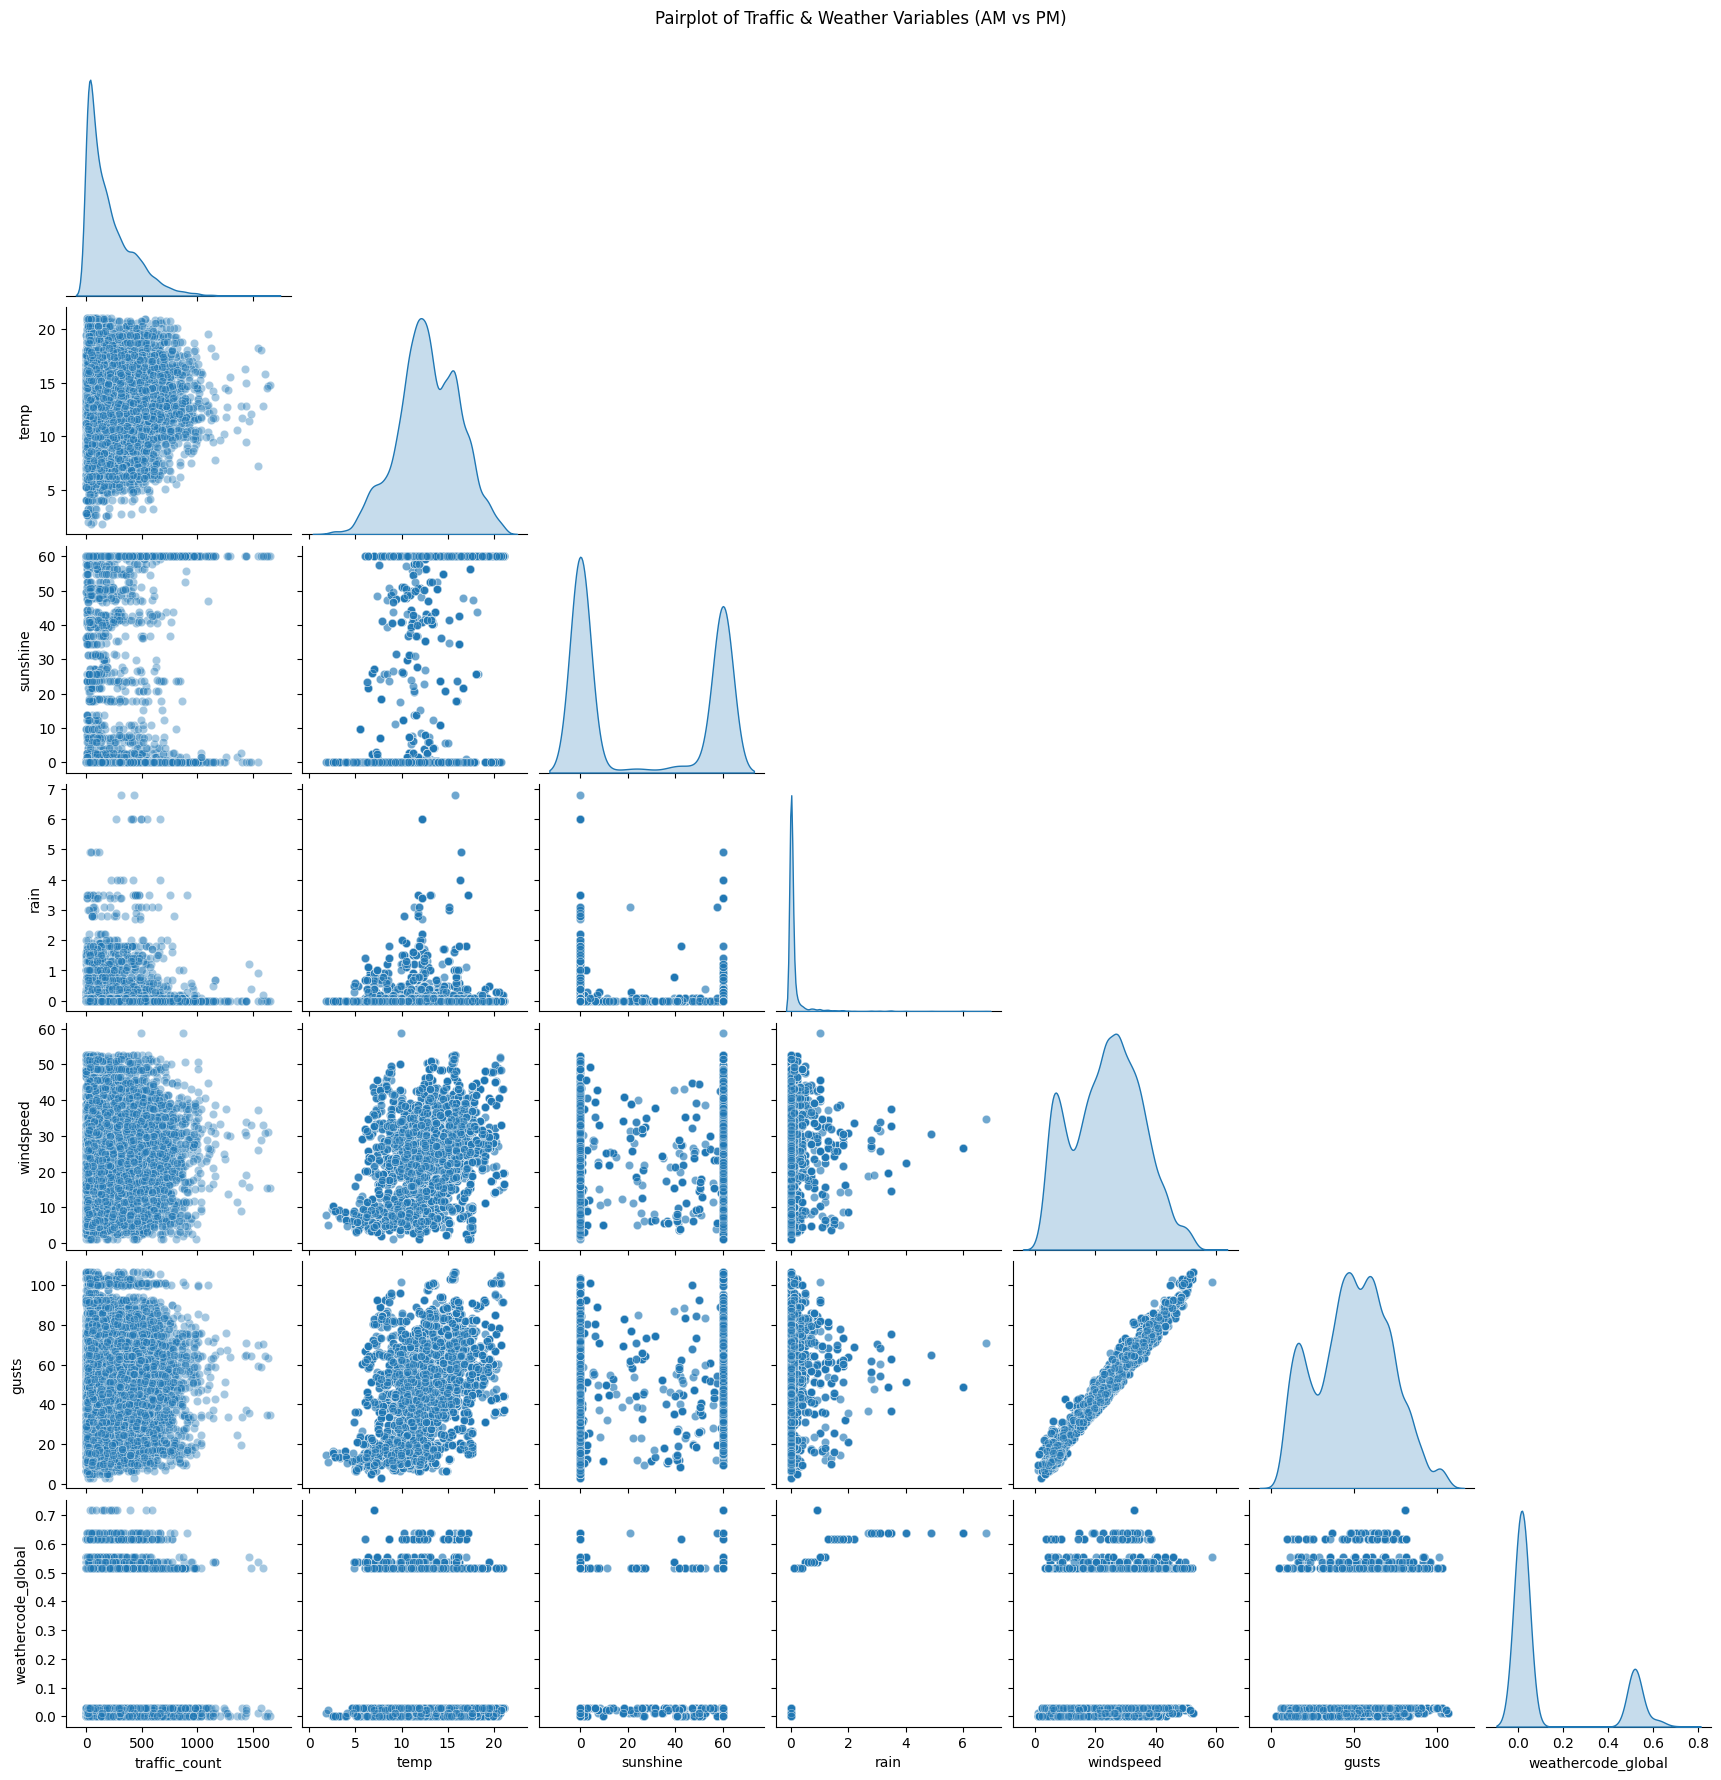

In [ ]:
## Pairplot, continuous predictors vs traffic_count

# Convert Spark DataFrame to Pandas
pdf = df_model.toPandas()

# Map time_binary for readability
pdf["time_of_day"] = pdf["time_binary"].map({1: "AM", 0: "PM"})

# Select continuous variables + target
cont_vars = [
    "traffic_count",
    "temp",
    "sunshine",
    "rain",
    "windspeed",
    "gusts",
    "weathercode_global",
    "time_of_day"
    ]

# Pairplot with hue
sns.pairplot(pdf[cont_vars],
             diag_kind="kde",
             corner=True,
             plot_kws={"alpha":0.4})

plt.suptitle("Pairplot of Traffic & Weather Variables (AM vs PM)", y=1.02)
plt.savefig("plot25_pairplot_traffic_weathernohue_.png", dpi=250, bbox_inches="tight")
plt.show()


**Pairplot AM vs PM**
**Traffic vs...**


*   minutes of sunshine:  We can ignore the higher traffic counts for afternoon-evening periods on days with a greater duration of sunshine - minutes of sunshine are accumulated across the day; the majority of morning traffic will be reacting to low sunshine in the preceding hour.
*   rain: Traffic counts are most consistent when there has been no rain in the previous hour. Traffic counts are higher for the range 0-2mm of rain in the previous hour. Notice there is a gap in traffic counts corresponding to rain of 2-3mm, and another between 4-6mm. We see far sparser traffic counts for rain quantities of 3-4mm, and minimal counts at 6mm.
*  gusts: Overall, gusts of 10-90 Km/h in the previous hour result in traffic counts being capped at around 1000 per hour period. There are a few outliers with traffic counts exceeding 1000 per hour, measured when gusts had reached between 10Km/h and 100m/sec, but traffic counts did not exceed 1,250 per hour when gusts exceeded ~75 Km/h.
* windspeed: Similar to gusts, traffic counts generally did not exceed 1000 measurements per hour, but for those that did, there were no traffic counts when windspeed measured > 40Km/h in the previous hour.

*Other observations:*
Windspeed and temperature have a similar pattern to gusts and temperature; the strongest gusts and highest wind speeds occur with the highest temperatures (>= 15 degrees Celcius). While this is generally true for both windspeed and gusts, it is true more often for gusts because this weather metric is already capturing much higher windspeeds.

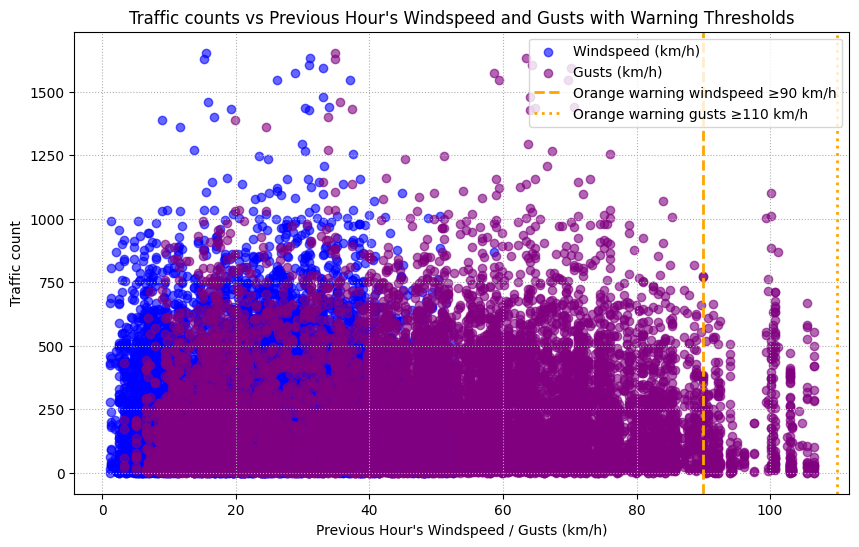

In [ ]:
## Plot showing windspeed

df = pdf  # your pandas DataFrame

plt.figure(figsize=(10,6))

# Scatter plots
plt.scatter(df["windspeed"], df["traffic_count"],
            color="blue", alpha=0.6, label="Windspeed (km/h)")
plt.scatter(df["gusts"], df["traffic_count"],
            color="purple", alpha=0.6, label="Gusts (km/h)")

# Orange warning thresholds
plt.axvline(x=90, color="orange", linestyle="--", linewidth=2,
            label="Orange warning windspeed ≥90 km/h")
plt.axvline(x=110, color="orange", linestyle=":", linewidth=2,
            label="Orange warning gusts ≥110 km/h")

# Labels and legend
plt.xlabel("Previous Hour's Windspeed / Gusts (km/h)")
plt.ylabel("Traffic count")
plt.title("Traffic counts vs Previous Hour's Windspeed and Gusts with Warning Thresholds")
plt.legend()
plt.grid(True, linestyle=":")
plt.savefig("plot26_scatterplot_traffic_windspeed_gustsWARNINGS_.png", dpi=250, bbox_inches="tight")
plt.show()

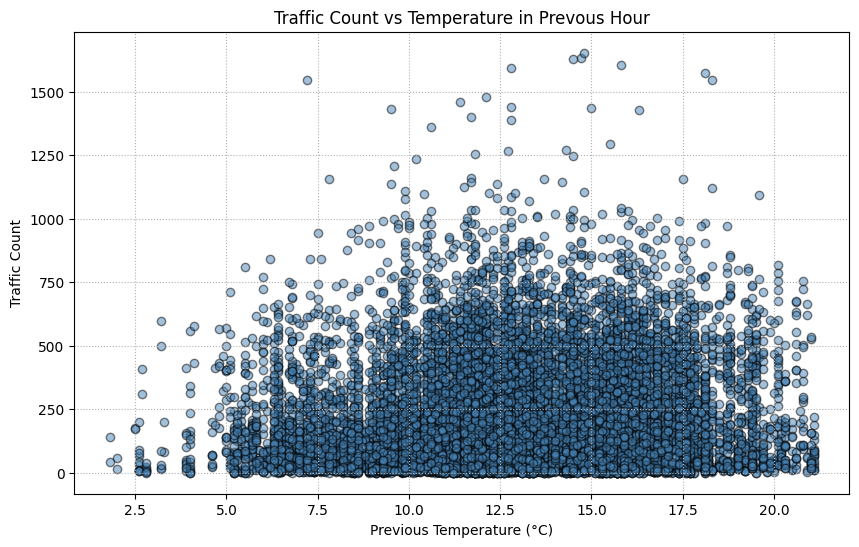

In [ ]:
## Plot temp_prev vs traffic_count, showing density

plt.figure(figsize=(10,6))

# Scatter plot
plt.scatter(pdf["temp"], pdf["traffic_count"],
            alpha=0.5, color="steelblue", edgecolor="k")

# Labels and title
plt.xlabel("Previous Temperature (°C)")
plt.ylabel("Traffic Count")
plt.title("Traffic Count vs Temperature in Prevous Hour")

# Optional: add grid
plt.grid(True, linestyle=":")
plt.savefig("plot27_scatterplot_traffic_temp_.png", dpi=250, bbox_inches="tight")
plt.show()

**Scatterplot traffic count vs previous temperature**
Traffic counts are most consistent in relation to temperatures in the previous hour between ~8.75 degreesC and 17.5 degreesC. Surprisingly, there are lower traffic counts relative to the lowest temperatures on this scale (0 - 5degreesC), although that may relate to the temperature range of 1-21 degreesC specific to this dataset. Lower temperatures may not be as common in the measured period for the earliest time of day used here, 5:00am. Notably, higher temperatures probably relate to the start of the afternoon/evening commute.

In [ ]:
pdf.head()

zone  traffic_count assignment_type  temp  sunshine  rain  windspeed  \
0  north            156          direct  10.0    0.0000   0.0       21.7   
1  north             53          direct  10.8   48.8155   0.0        9.3   
2  south            420          direct  16.8   60.0000   0.0       12.7   
3  south            110          direct  19.1   60.0000   0.0       11.2   
4   west              7          direct   7.5    0.0000   0.0        6.5   

   gusts  wind_direction wind_direction_desc  weathercode_global  \
0   44.3               6                   N            0.020202   
1   18.7             344                   N            0.010101   
2   32.0             331                  NW            0.030303   
3   31.3             354                   N            0.030303   
4   14.0              34                  NE            0.030303   

   hour_of_peak  time_binary  move_centrally  is_spring  is_summer  is_autumn  \
0             2            1               0          0          0          0   
1             3            0               0          0          0          0   
2             2            0               0          0          0          1   
3             3            0               0          0          1          0   
4             2            1               1          0          0          1   

   is_winter time_of_day  
0          1          AM  
1          1          PM  
2          0          PM  
3          0          PM  
4          0          AM

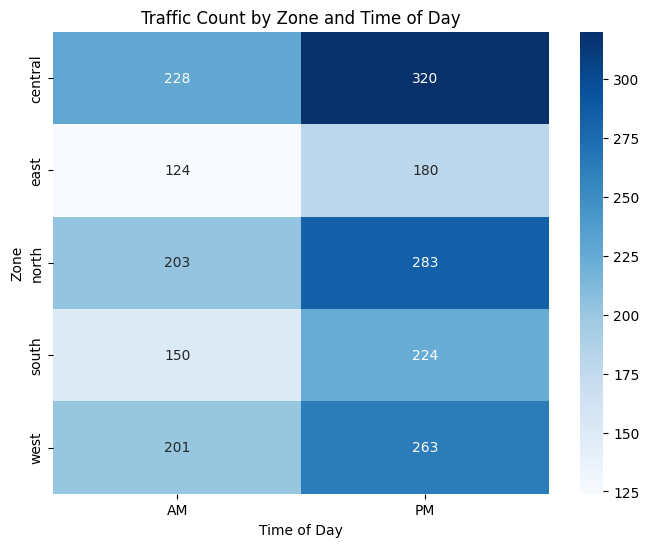

In [ ]:
## Heatmap time of day, zones, traffic_count

# Pivot the data so rows = zones, columns = time_of_day, values = traffic_count
heatmap_data = (
    pdf
    .groupby(["zone", "time_of_day"])["traffic_count"]
    .mean()   # or sum, depending on what you want
    .unstack(fill_value=0)
)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="Blues"   # gradient colormap
)
plt.title("Traffic Count by Zone and Time of Day")
plt.ylabel("Zone")
plt.xlabel("Time of Day")
plt.savefig("plot28_heatmap_zones_timeofday_.png", dpi=250, bbox_inches="tight")
plt.show()


In [ ]:
# Drop wind_direction column
df_model = df_model.drop('wind_direction',"assignment_type")

In [ ]:
# rename wind_direction_prev_desc to wind_direction
df_model = df_model.withColumnRenamed("wind_direction_desc", "wind_direction")

### Export cleaned traffic and weather data to .csv

In [ ]:
# Export cleaned traffic and weather data to .csv
df_model.coalesce(1).write.csv("/content/drive/MyDrive/Colab Notebooks/data_cleaning_output5.csv", header=True)